In [2]:
if (!requireNamespace('BiocManager', quietly = TRUE))
install.packages('BiocManager')

# BiocManager::install('EnhancedVolcano')

BiocManager::install('airway')


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.10 (BiocManager 1.30.15), R 3.6.3 (2020-02-29)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'airway'”
Old packages: 'ape', 'backports', 'bbmle', 'BH', 'BiocManager', 'blob', 'brew',
  'brio', 'broom', 'cachem', 'car', 'carData', 'caret', 'class', 'cli',
  'clipr', 'cluster', 'coin', 'colorspace', 'commonmark', 'conflicted',
  'conquer', 'corpcor', 'corrplot', 'cpp11', 'crayon', 'credentials',
  'crosstalk', 'curl', 'data.table', 'DBI', 'dendextend', 'desc', 'devtools',
  'dials', 'diffobj', 'digest', 'doParallel', 'dplyr', 'DT', 'dtplyr', 'e1071',
  'europepmc', 'evaluate', 'fansi', 'fastcluster', 'fastmatch', 'fdrtool',
  'fields', 'foreach', 'formatR', 'fs', 'furrr', 'future', 'gargle', 'gee',
  'geepack', 'GeneNet', 'generics', 'ger

In [3]:
.mySampleScoreArrangerFn=function(inputPath){
  #This function reads in the sample scores (between 0 and 1)
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/"
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

  resCombined=list()
  # tmpFiles=list.files(inputPath)
  tmpFiles = read.table(paste0(inputPath,"dataList.txt"))
  path=unlist(strsplit(inputPath,"/"))
  path=path[-length(path)]
  path=paste(path,collapse = "/")
  path=paste0(path,"/")
  # tmpFiles = as.vector(tmpFiles)
  if((length(tmpFiles))!=25){
    print(paste("caution: number of files is",(length(tmpFiles$V1))))
  }
  
  for(i in 1:(length(tmpFiles$V1))){
    # 
    # strsplit(status,"_")

    load(paste0(path,tmpFiles$V1[i],"results.rda"))
    
    tmp=result$ROCdf
    
    resdf=list()
    for(j in 1:length(tmp)){
      #print(j)
      tmpdf=tmp[[j]][[1]]
      tmpdf$status=tmp[[j]][[2]]
      colnames(tmpdf)=c("sampleName","real","estimated","status")
      resdf=c(resdf,list(tmpdf))
    }
    resdf=do.call("rbind",resdf)
    resdf=resdf[!duplicated(paste0(resdf$sampleName,"_",resdf$status)),]
    resCombined=c(resCombined,list(resdf))
  }
  
  return(resCombined)
}
.myClassificationEvaluationFn=function(testLabelsHat,testLabels){
  require(PRROC,quietly=T)
  require(pROC,quietly=T)
  
  finalResPR=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)$auc.integral
  finalResROC=as.numeric(roc(response=testLabels,predictor=as.vector(testLabelsHat))$auc)
  
  return(list(ROC=finalResROC,PR=finalResPR,ROCdata=roc(response=testLabels,predictor=as.vector(testLabelsHat)),PRdata=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)))
}
.myResultOrganizerFn=function(inputPath,countThr=NULL,replaceZero=F){
  #results with number of folds less than the countThr are set to zero
  #zeros can be replaced with 0.5 (ROC and PR)
  load(inputPath)
  inputData=ROCres
  
  if(is.null(countThr)){
    countThr=max(inputData[[2]])
  }
  
  inputData[[1]][inputData[[2]]<countThr]=0
  if(replaceZero){
    inputData[[1]][inputData[[1]]==0]=0.5
  }
  res=inputData[[1]]
  
  thr=0
  if(replaceZero){
    thr=0.5
  }
  x=apply(res,1,function(x) sum(x==thr))
  res=res[which(x<(ncol(inputData[[1]])-1)),]
  return(res)
}

In [4]:
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




test

In [5]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red",'purple')
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1410   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8908918        0.9022770        0.8946869        0.8927894 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8880455        0.8946869        0.8937381        0.8937381 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8937381        0.8913662        0.8913662        0.8951613 


pdf 
  2

### for ld_data

In [6]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/ld_runner/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red",'purple')
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1410   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8799020        0.8566176        0.8799020        0.8149510 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8786765        0.8799020        0.8762255        0.8799020 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8750000        0.8431373        0.8492647        0.8511029 


pdf 
  2

In [7]:
data_ld=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/ld_runner/")
# dim(data) in train+ main "4209360 4
# dim(data) in main 3748014
data_ld=do.call("rbind",data_ld)
status=gsub("^independent","^independent_1",data_ld$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x) paste(x[3:length(x)],collapse = "_")))
data_ld$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 5"


### for longitudinal

In [8]:
data_longitudinal=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_longitudinal/")
# dim(data) in train+ main "4209360 4
# dim(data) in main 3748014
data_longitudinal=do.call("rbind",data_longitudinal)
status=gsub("^independent","^independent_1",data_longitudinal$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x) paste(x[3:length(x)],collapse = "_")))
data_longitudinal$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 5"


In [9]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red",'purple')
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1410   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8908918        0.9022770        0.8946869        0.8927894 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8880455        0.8946869        0.8937381        0.8937381 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8937381        0.8913662        0.8913662        0.8951613 


pdf 
  2

Saving 7 x 7 in image



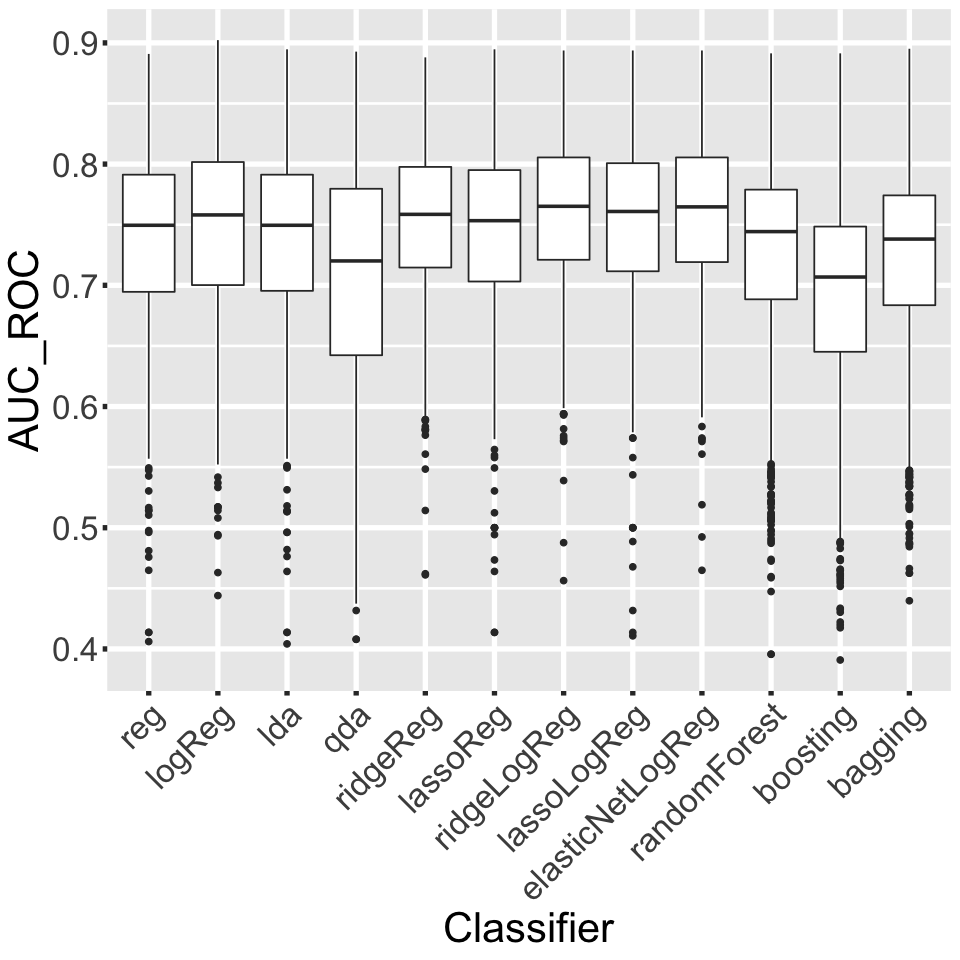

In [10]:
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
temp_data=melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
# pdf(file=paste0(inputPath,"test_boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
ggsave(paste0(inputPath,"myplot.png"))


# main

In [11]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red")
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1320   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8731897        0.8551711        0.8741877        0.8399541 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8573805        0.8692222        0.8551384        0.8560352 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8557890        0.8332094        0.8308230        0.8382445 


pdf 
  2

In [12]:
temp_data = melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
pdf(file = paste0(inputPath,"boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
dev.off()


pdf 
  2

Saving 7 x 7 in image



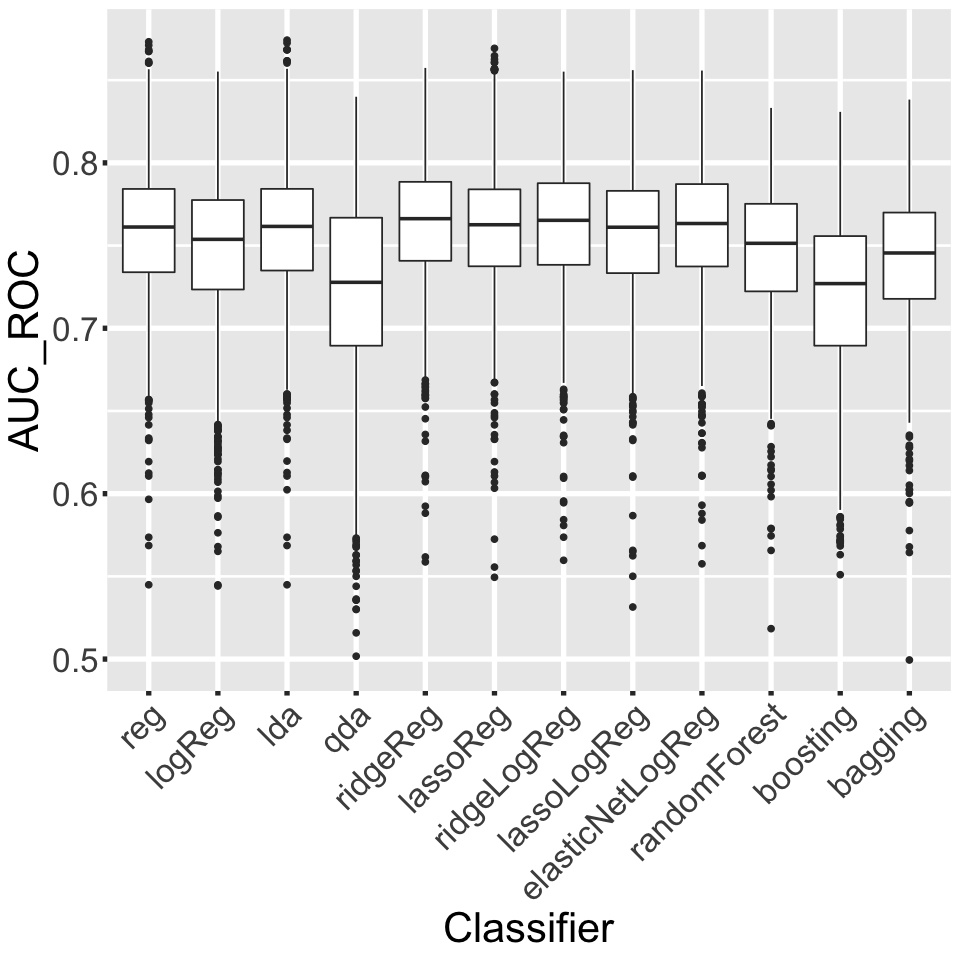

In [13]:
# png(file=paste0(inputPath,"boxplot.png"), width = 4, height = 4.5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
# dev.off()
ggsave(paste0(inputPath,"boxplot.png"))

In [14]:
data=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/")

# dim(data) in train+ main "4209360 4
# dim(data) #in main 3748014
data=do.call("rbind",data)
status=gsub("^independent","^independent_1",data$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 25"


In [15]:
dim(data)
# 3748014 5

[1] 3748014       5

In [16]:
data_1=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/")
# dim(data) in train+ main "4209360 4
# dim(data) in main 3748014
data_1=do.call("rbind",data_1)
status=gsub("^independent","^independent_1",data_1$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data_1$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 5"


In [17]:
# data=rbind(data, data_1, data_ld, )
data=rbind(data, data_1, data_ld, )

ERROR: Error in rbind(data, data_1, data_ld, ): argument is missing, with no default


In [ ]:
dim(data_1)
dim(data_ld)
dim(data)

In [ ]:
#weighting the scores based on the model's ROC

x=as.data.frame(weightsROC)
x$id=row.names(x)
x=reshape2::melt(x,by="id")

# x=as.data.frame(weightsROC)
# x$id=row.names(x)
# x=reshape2::melt(x,by="id")

x2=strsplit(x$id,"_")
x2=unlist(lapply(x2,function(x)paste(x[2:length(x)],collapse = "_")))
x2=paste0(x2,"_",as.character(x$variable))
x2=gsub("independent","real",x2)
# x2=gsub("perm1","real",x2)
# x2=gsub("perm2","real",x2)
# x2=gsub("perm3","real",x2)
# x2=gsub("perm4","real",x2)
# x2=gsub("perm5","real",x2)
x$status=x2
                 



In [ ]:
dim(data) # main 2772000 258240 3794580 . 5
data=data[data$statusUpdated %in% x$status,]
x=x[x$status %in% data$statusUpdated,]

In [18]:
x=x[,c("status","value")]
colnames(x)[2]="weightROC"
data=merge(data,x,by.x='statusUpdated',by.y="status")
rm(x)


In [19]:
# check for data abnormal, tmp is null is safe
tmp=as.data.frame(table(data$status[data$estimated>1]))
tmp
tmp=strsplit(as.character(tmp$Var1),"_")
tmp=unlist(lapply(tmp,function(x) x[length(x)]))

Freq
<int>


In [20]:
data=data[which(data$estimated>=0 & data$estimated<=1),]
data$id=paste0(data$statusUpdated,"_",data$sampleName)
data=list(data=data)
data$average=aggregate(estimated~id,data=data$data,FUN=mean)
                 

In [21]:
save(data, file="/Volumes/Work/Vahid_work/classification_newcode_data/tempero_1.rda")


In [22]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/tempero_1.rda")

data3=data$data[,c("id","sampleName","real","statusUpdated","weightROC")]
data3=data3[!duplicated(data3$id),]
data3=merge(data$average,data3,by="id")
data$average=data3
rm(data3)
                      
data$average$modWeightROC=data$average$weightROC-0.7  
data$average$modWeightROC[which(data$average$modWeightROC<0)]=0


In [23]:
length(data$average$weightROC)# 3849588

[1] 3849588

# Using the model that >0.8 in the main

In [24]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")

row.names(dataTest$data$weightsROC)=gsub("independent","real",row.names(dataTest$data$weightsROC))

x=dataTest$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures= c()
sl_models = c()
sl_model_main = c()
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataTest$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.8){
    counter=counter+1
    slFeatures=c(slFeatures, row.names(dataMain$data$weightsROC)[x2$row[i]])
    sl_models=c(sl_models, paste(row.names(dataMain$data$weightsROC)[x2$row[i]], colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))
  }
    sl_model_main=c(sl_model_main, paste(row.names(dataMain$data$weightsROC)[x2$row[i]], colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))

}
# sl_models
name_refined = c()
for(i in 1:length(sl_models)){
  temp_name = unlist(strsplit(sl_models[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_refined = c(name_refined, temp_name)
}
name_main_refined = c()

for(i in 1:length(sl_model_main)){
  temp_name = unlist(strsplit(sl_model_main[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_main_refined = c(name_main_refined, temp_name)
}
length(name_refined)
length(name_main_refined)

[1] 742

[1] 1822

In [25]:
dataMain$data$weightsROC

,reg,logReg,lda,qda,ridgeReg,lassoReg,ridgeLogReg,lassoLogReg,elasticNetLogReg,randomForest,boosting,bagging
real_no_no_sis,0.7294581,0.7040649,0.7301160,0.6260754,0.7274942,0.7329406,0.7086501,0.7046551,0.7086428,0.6925670,0.6827051,0.6929654
real_no_grn4_sis,0.7276292,0.7001263,0.7289581,0.6951982,0.7237038,0.7271014,0.6932554,0.6973704,0.6952948,0.7187834,0.7294414,0.7078099
real_no_grn4Cntl_sis,0.7430678,0.7485035,0.7437388,0.7193649,0.7436156,0.7427165,0.7450098,0.7478017,0.7456677,0.7134800,0.7479008,0.7096913
real_no_grn5_sis,0.7354574,0.7343691,0.7365178,0.7090360,0.7436482,0.7357799,0.7385123,0.7337375,0.7378251,0.7551179,0.7414837,0.7388089
real_no_grn5Cntl_sis,0.7838541,0.7693112,0.7855646,0.7771771,0.7808365,0.7845485,0.7706596,0.7713741,0.7692634,0.7538030,0.7270991,0.7491136
real_no_grn1_sis,0.7378022,0.7333631,0.7384533,0.6927987,0.7354957,0.7374621,0.7271764,0.7326472,0.7306194,0.7034572,0.7177590,0.6910317
real_no_grn1Cntl_sis,0.7279250,0.7313982,0.7285849,0.7075004,0.7308178,0.7285483,0.7272608,0.7307188,0.7279410,0.7227710,0.7299754,0.7120556
real_no_grn2_sis,0.7445305,0.7500882,0.7445161,0.7157039,0.7485788,0.7438717,0.7499026,0.7521042,0.7513650,0.7491664,0.6959178,0.7455081
real_no_grn2Cntl_sis,0.7269951,0.7176199,0.7266072,0.6821655,0.7313695,0.7269951,0.7215009,0.7175136,0.7228158,0.7278042,0.7333515,0.7166167
real_no_grn3_logisticFwd,0.7099161,0.6788928,0.7071807,0.6785615,0.7306298,0.7403387,0.7239285,0.7174524,0.7126145,0.7785614,0.7473387,0.7853970


In [26]:
library('reshape2')
akk <- melt(dataMain$data$weightsROC, na.rm= TRUE, id.vars="route",
                   value.name="score", variable.name="cls" )
# dataMain$data$weightsROC>0.8

In [27]:
min(akk$score)
#0.499457542666189

[1] 0.4994575

In [28]:
x=dataTest$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]
x

,reg,logReg,lda,qda,ridgeReg,lassoReg,ridgeLogReg,lassoLogReg,elasticNetLogReg,randomForest,boosting,bagging
real_no_no_sis,0.7950664,0.8130930,0.7950664,0.7286528,0.7941176,0.7950664,0.8102467,0.8092979,0.8102467,0.7713472,0.7523719,0.7632827
real_no_grn4_sis,0.6110057,0.6404175,0.6110057,0.5588235,0.6176471,0.6138520,0.6499051,0.6489564,0.6499051,0.7148956,0.6740987,0.6963947
real_no_grn4Cntl_sis,0.6570209,0.6840607,0.6574953,0.6612903,0.6665085,0.6570209,0.6897533,0.6907021,0.6869070,0.7144213,0.7144213,0.7134725
real_no_grn5_sis,0.5104364,0.4933586,0.5132827,0.5066414,0.5142315,0.5123340,0.4876660,0.4886148,0.4924099,0.5460152,0.5047438,0.5431689
real_no_grn5Cntl_sis,0.6793169,0.6992410,0.6793169,0.6195446,0.6703036,0.6750474,0.6840607,0.6916509,0.6840607,0.6418406,0.5891841,0.6143264
real_no_grn1_sis,0.6110057,0.6404175,0.6110057,0.5588235,0.6214421,0.6195446,0.6489564,0.6499051,0.6489564,0.7106262,0.6750474,0.6883302
real_no_grn1Cntl_sis,0.6641366,0.6707780,0.6641366,0.6110057,0.6850095,0.6641366,0.6802657,0.6802657,0.6831120,0.7419355,0.7362429,0.7267552
real_no_grn2_sis,0.6598672,0.6584440,0.6593928,0.7106262,0.6475332,0.6484820,0.6574953,0.6612903,0.6565465,0.6195446,0.6665085,0.5925047
real_no_grn2Cntl_sis,0.6380455,0.6309298,0.6385199,0.5151803,0.6423150,0.6380455,0.6527514,0.6347249,0.6470588,0.7006641,0.6850095,0.6769450
real_no_grn3_logisticFwd,0.6375712,0.6432638,0.6347249,0.5436433,0.6366224,0.6427894,0.6318786,0.6347249,0.6375712,0.6148008,0.4886148,0.6366224


In [29]:
make_composite = TRUE        
if(make_composite){
print(paste0(sum(data$average$statusUpdated %in% name_refined), " subjects used to make composite model"))
    # in train+ main "258240 subjects used to make composite model"
data$average$modWeightROC[which(!data$average$statusUpdated %in% name_refined)] = 0.0
}
data$average$weightedEstimate = data$average$estimated*(data$average$modWeightROC)^2
 # 178080 182376

[1] "182376 subjects used to make composite model"


[1] 182376

[1] 182376

[1] 3849588

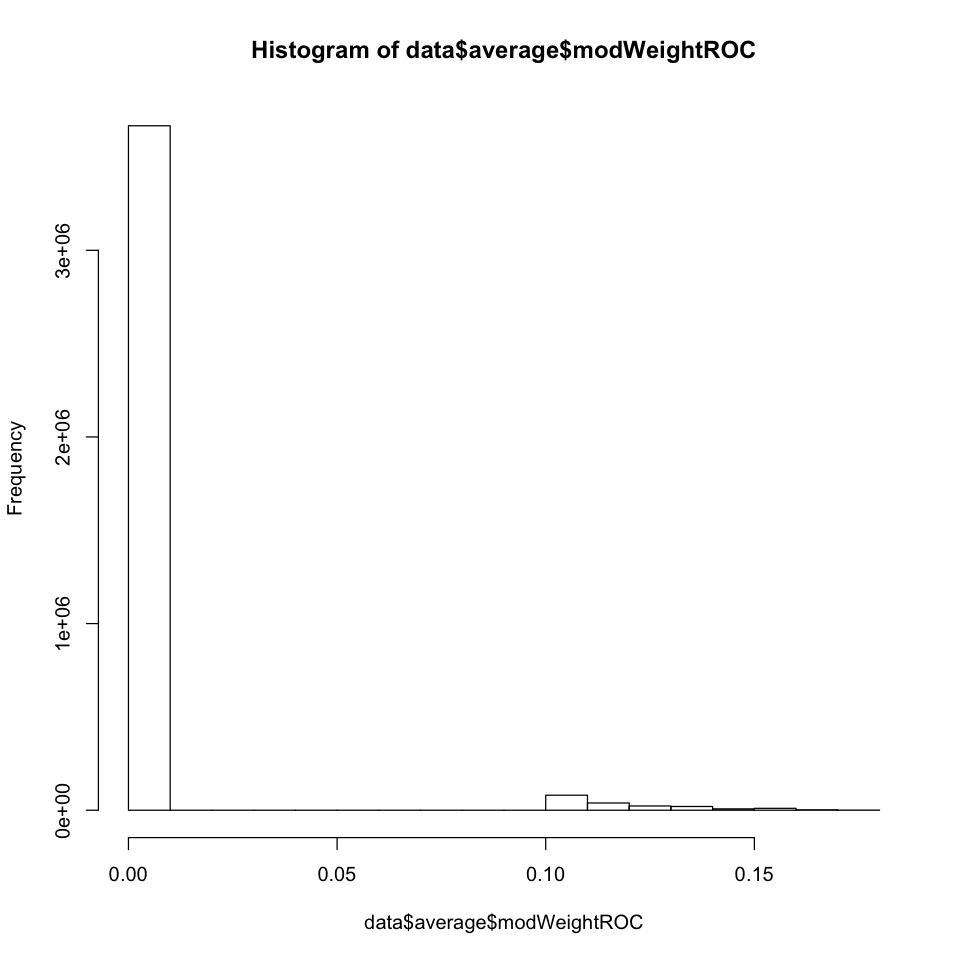

In [30]:
sum(data$average$statusUpdated %in% name_refined)
# sum(data$average$statusUpdated %in% name_main_refined)
sum(data$average$modWeightROC>0)
length(data$average$modWeightROC)
hist(data$average$modWeightROC)

In [50]:
# save(data, file="/Volumes/Work/Vahid_work/classification_newcode_data/tempero_data.rda")
load(file="/Volumes/Work/Vahid_work/classification_newcode_data/tempero_data.rda")

In [51]:
# data3=data$average
# data3$dx=paste0(data3$statusUpdated,"_dx",data3$real)
# tmp=data3[,c("dx","real")]
# tmp=tmp[!duplicated(tmp$dx),]
# data3med=aggregate(weightedEstimate~dx,data=data3,median)
# data$overallSubjectMean=merge(data3med,tmp,by="dx")
# rm(tmp,data3med,data3)
# status=data$overallSubjectMean$dx
# status=strsplit(status,"_")
# status=unlist(lapply(status,function(x) paste(x[1:(length(x)-1)],collapse = "_")))
# data$overallSubjectMean$status=status
# rm(status)
data$average$group='test'
data$average$group[which(data$average$sampleName %in% dataLD_ASD$data$concensus$sampleName)]='test'
data$average$group[which(data$average$sampleName %in% dataTest$data$concensus$sampleName)]='test'
data$average$group[which(data$average$sampleName %in% dataMain$data$concensus$sampleName)]='main'



In [52]:
dataLD_ASD$data$concensus$sampleName

[1] "100" "13"  "18"  "181" "189" "2"   "210" "230" "25"  "26"  "263" "287"
[13] "299" "316" "321" "33"  "330" "346" "350" "357" "37"  "378" "384" "385"
[25] "389" "39"  "392" "42"  "45"  "46"  "47"  "48"  "49"  "51"  "52"  "57" 
[37] "6"   "60"  "63"  "64"  "65"  "68"  "69"  "72"  "73"  "74"  "75"  "76" 
[49] "77"  "79"  "80"  "82"  "85"  "9"   "90"  "96"  "98"  "99"

In [65]:
table(data$average$group)


     ld    main    test 
 631032 2905282  524520 

# output for main

In [16]:
# the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])
# the_mean

In [32]:
# data$concensus$real
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)

In [97]:
tmp=dcast(data = data$average[which(data$average$group=='main'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])
the_mean_td = mean(data$concensus$weightedEstimate[data$concensus$real==0])
the_mean_td
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.625)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.58)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.530)))

print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.525)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.520)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.510)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.45)))

print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC

df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

the_mean
df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"Figure_2_heatmap.a.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
#eval(hm$call)
dev.off()


NULL

[1] 0.3372067

[1] 175

   
    FALSE TRUE
  0    81    1
  1    76   17
   
    FALSE TRUE
  0    80    2
  1    60   33
   
    FALSE TRUE
  0    76    6
  1    55   38
   
    FALSE TRUE
  0    75    7
  1    47   46
   
    FALSE TRUE
  0    73    9
  1    41   52
   
    FALSE TRUE
  0    72   10
  1    37   56
   
    FALSE TRUE
  0    71   11
  1    34   59
   
    FALSE TRUE
  0    71   11
  1    30   63
   
    FALSE TRUE
  0    70   12
  1    26   67
   
    FALSE TRUE
  0    70   12
  1    23   70
   
    FALSE TRUE
  0    69   13
  1    23   70
   
    FALSE TRUE
  0    68   14
  1    23   70
   
    FALSE TRUE
  0    67   15
  1    22   71
   
    FALSE TRUE
  0    67   15
  1    21   72
   
    FALSE TRUE
  0    60   22
  1    19   74


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8467086

$PR
[1] 0.8434521

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 82 controls (testLabels 0) < 93 cases (testLabels 1).
Area under the curve: 0.8467

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8434521 

    Area under curve (Davis & Goadrich):
     0.8432302 

    Curve not computed ( can be done by using curve=TRUE )



[1] 0.7156527

pdf 
  2

In [98]:
tmp=dcast(data = data$average[which(data$average$group=='test'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
# the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])
# the_mean_td = mean(data$concensus$weightedEstimate[data$concensus$real==0])
# the_mean_td
# length(data$concensus$real)
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.625)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.58)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.530)))

# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.525)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.520)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.510)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.45)))

# print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# # data$weightsROC=weightsROC

df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

the_mean
df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"Figure_2_heatmap.a.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
#eval(hm$call)
dev.off()
write.table(data$concensus, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/LD_asd_score.csv",sep = ",")


NULL

# output for test

In [84]:
tmp=dcast(data = data$average[which(data$average$group=='test'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")
#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.625)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.58)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.53)))

print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.525)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.520)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.510)))

print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.45)))

print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC
             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"

pdf(file=paste0(inputPath,"Figure_2_heatmap.b.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
dev.off()

write.table(data$concensus, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_asd_score.csv",sep = ",")


NULL

[1] 65

   
    FALSE TRUE
  0    31    0
  1    27    7
   
    FALSE TRUE
  0    31    0
  1    21   13
   
    FALSE TRUE
  0    30    1
  1    19   15
   
    FALSE TRUE
  0    30    1
  1    15   19
   
    FALSE TRUE
  0    29    2
  1    13   21
   
    FALSE TRUE
  0    28    3
  1    13   21
   
    FALSE TRUE
  0    28    3
  1    11   23
   
    FALSE TRUE
  0    27    4
  1    11   23
   
    FALSE TRUE
  0    25    6
  1    11   23
   
    FALSE TRUE
  0    24    7
  1    10   24
   
    FALSE TRUE
  0    24    7
  1    10   24
   
    FALSE TRUE
  0    24    7
  1    10   24
   
    FALSE TRUE
  0    24    7
  1     9   25
   
    FALSE TRUE
  0    24    7
  1     9   25
   
    FALSE TRUE
  0    24    7
  1     5   29


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8785579

$PR
[1] 0.8971129

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 31 controls (testLabels 0) < 34 cases (testLabels 1).
Area under the curve: 0.8786

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8971129 

    Area under curve (Davis & Goadrich):
     0.897095 

    Curve not computed ( can be done by using curve=TRUE )



pdf 
  2


# output for all

In [18]:
head(data$average)

,id,estimated,sampleName,real,statusUpdated,weightROC,modWeightROC,weightedEstimate,group
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,cov_grn1_cppls_bagging_100,0.031,100,1,cov_grn1_cppls_bagging,0.7340489,0,0,test
2,cov_grn1_cppls_bagging_101,0.277,101,1,cov_grn1_cppls_bagging,0.7340489,0,0,main
3,cov_grn1_cppls_bagging_102,0.096,102,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
4,cov_grn1_cppls_bagging_104,0.124,104,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
5,cov_grn1_cppls_bagging_105,0.594,105,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
6,cov_grn1_cppls_bagging_106,0.003,106,1,cov_grn1_cppls_bagging,0.7340489,0,0,main


In [19]:
# normalize the score with main and test

NULL

[1] 264

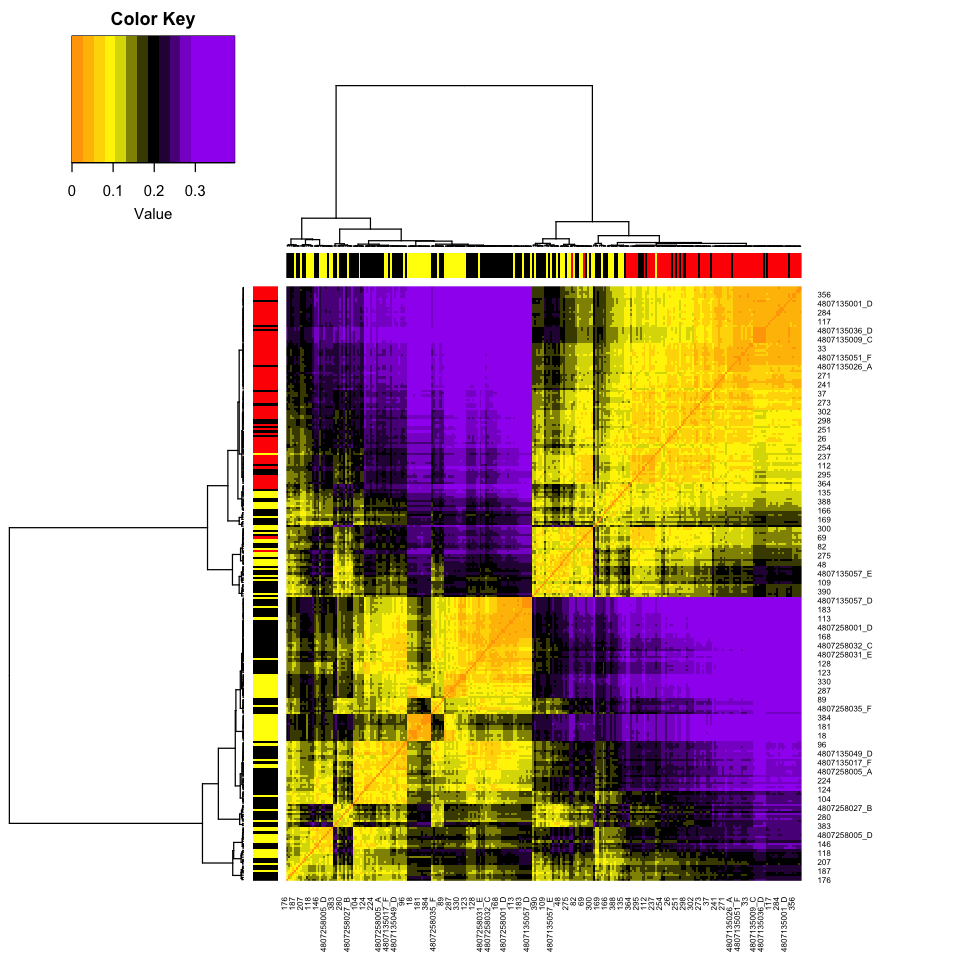

In [53]:
tmp=dcast(data = data$average, formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.58)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.53)))

# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.525)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.520)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.510)))

# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
# print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.45)))
# print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

data$weightsROC=weightsROC
data$PR_values=PRs
data$concensus$real[which(data$concensus$sampleName %in% dataLD_ASD$data$concensus$sampleName[which(dataLD_ASD$data$concensus$real==1)])]=1.5
dataTandM=list(data=data)

             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"

labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'yellow')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]

#   pdf(file=paste0(inputPath,"heatmap.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 

In [55]:
data$concensus$real[which(data$concensus$sampleName %in% dataLD_ASD$data$concensus$sampleName[which(dataLD_ASD$data$concensus$real==1)])]


[1] 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
[20] 1.5 1.5 1.5 1.5 1.5

In [40]:
data$concensus$sampleName 

[1] "100"          "101"          "102"          "104"          "105"         
  [6] "106"          "107"          "109"          "110"          "111"         
 [11] "112"          "113"          "116"          "117"          "118"         
 [16] "119"          "121"          "122"          "123"          "124"         
 [21] "125"          "126"          "128"          "129"          "13"          
 [26] "130"          "131"          "132"          "134"          "135"         
 [31] "139"          "145"          "146"          "150"          "152"         
 [36] "153"          "154"          "155"          "163"          "164"         
 [41] "166"          "167"          "168"          "169"          "170"         
 [46] "172"          "174"          "175"          "176"          "18"          
 [51] "180"          "181"          "182"          "183"          "185"         
 [56] "187"          "189"          "19"           "191"          "193"         
 [61] "195"          "197"          "198"          "2"            "200"         
 [66] "201"          "203"          "205"          "207"          "208"         
 [71] "210"          "211"          "214"          "215"          "216"         
 [76] "218"          "219"          "222"          "223"          "224"         
 [81] "230"          "231"          "232"          "235"          "237"         
 [86] "238"          "240"          "241"          "243"          "249"         
 [91] "25"           "250"          "251"          "252"          "254"         
 [96] "255"          "256"          "258"          "259"          "26"          
[101] "262"          "263"          "266"          "267"          "268"         
[106] "269"          "271"          "273"          "274"          "275"         
[111] "276"          "278"          "279"          "280"          "284"         
[116] "285"          "287"          "291"          "295"          "296"         
[121] "298"          "299"          "300"          "302"          "305"         
[126] "309"          "313"          "314"          "315"          "316"         
[131] "321"          "322"          "323"          "325"          "328"         
[136] "33"           "330"          "335"          "337"          "340"         
[141] "341"          "342"          "346"          "348"          "350"         
[146] "351"          "353"          "354"          "356"          "357"         
[151] "36"           "362"          "363"          "364"          "367"         
[156] "369"          "37"           "371"          "372"          "373"         
[161] "374"          "377"          "378"          "382"          "383"         
[166] "384"          "385"          "387"          "388"          "389"         
[171] "39"           "390"          "391"          "392"          "42"          
[176] "45"           "46"           "47"           "48"           "4807135001_D"
[181] "4807135001_E" "4807135003_A" "4807135006_A" "4807135006_F" "4807135009_C"
[186] "4807135011_C" "4807135012_B" "4807135012_C" "4807135016_A" "4807135016_C"
[191] "4807135016_E" "4807135017_B" "4807135017_F" "4807135019_E" "4807135020_B"
[196] "4807135020_D" "4807135021_D" "4807135023_D" "4807135024_E" "4807135026_A"
[201] "4807135026_F" "4807135031_E" "4807135036_C" "4807135036_D" "4807135042_A"
[206] "4807135042_B" "4807135048_D" "4807135049_D" "4807135049_F" "4807135051_B"
[211] "4807135051_D" "4807135051_E" "4807135051_F" "4807135057_C" "4807135057_D"
[216] "4807135057_E" "4807135060_C" "4807258001_D" "4807258005_A" "4807258005_C"
[221] "4807258005_D" "4807258016_E" "4807258027_A" "4807258027_B" "4807258027_D"
[226] "4807258027_F" "4807258031_A" "4807258031_E" "4807258032_C" "4807258033_B"
[231] "4807258034_E" "4807258035_D" "4807258035_F" "49"           "51"          
[236] "52"           "57"           "6"            "60"           "63"          
[241] "64"           "65"           "68"           "69"           "7"           
[246] "72"           "73"        

In [21]:
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra)
# install.packages("ggpubr")
# install.packages("factoextra")
library(ggpubr)

library(factoextra)

── Attaching packages ────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



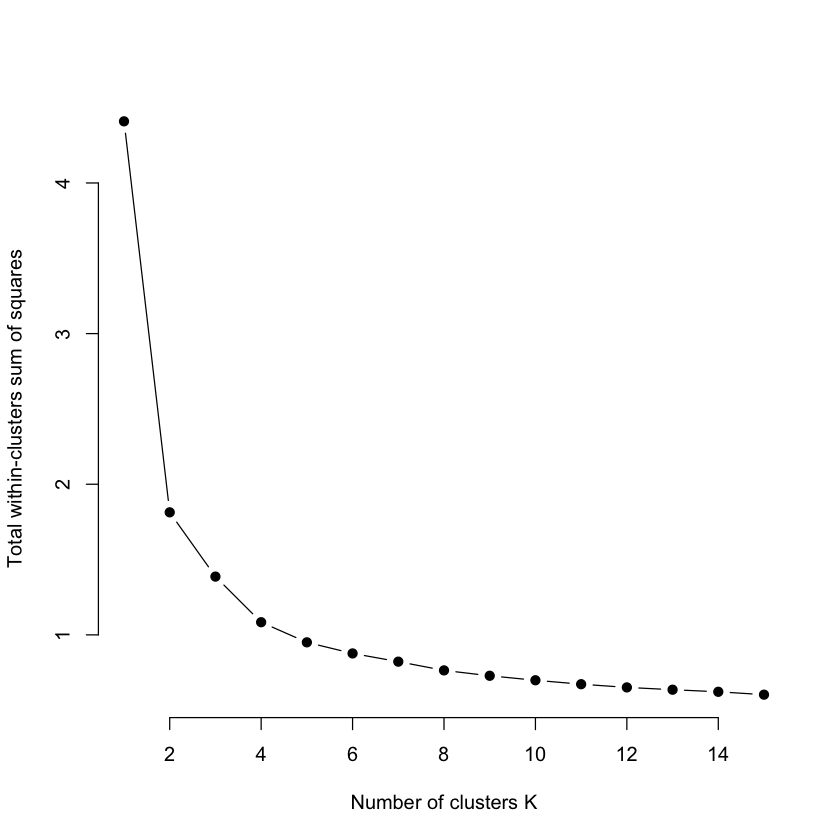

In [22]:
temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
temp_tmp = t(temp_tmp[,c(-1)])
res.km <- kmeans(temp_tmp, 4, nstart = 25)
# K-means clusters showing the group of each individuals
wss <- function(k) {
  kmeans(temp_tmp, k, nstart = 10 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")



In [ ]:
# res.km$real=dMain$real

In [ ]:
# temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
# temp_tmp = t(temp_tmp[,c(-1)])
# res.km <- kmeans(temp_tmp, 5, nstart = 25)
# p1 = fviz_cluster(res.km, data = temp_tmp,
#              geom = "point",
#              ellipse.type = "convex", 
#              ggtheme = theme_bw()
#              )


In [ ]:
# p1$data$real=dMain$real

In [ ]:
# ggplot(p1$data, aes(x=x, y=y)) +
#   geom_point(aes(shape=p1$data$cluster, color=p1$data$real),size=5)

# figure 3 x

In [ ]:
head(dataTandM$data$concensus)

In [57]:
# save(dataLD,dataMain,dataLong,dataTest,file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")
dataTandM$data$concensus$group='test'
dataTandM$data$concensus$group[which(dataTandM$data$concensus$sampleName %in% dataMain$data$concensus$sampleName)]='main'


# figure 3.x

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>
2,101,0.7736704,1,main,19,ASD,34.366,X3F5T
6,106,0.3833862,1,main,9,ASD,40.542,H3E8D
7,107,0.3280603,1,main,12,ASD,120.000,C2K6H
8,109,0.5667895,0,main,2,TD,34.825,Y2P2Z
9,110,0.4502608,0,main,1,TD,15.244,H7U8Q
10,111,0.9109924,1,main,13,ASD,30.292,M8K5X


[1] 0.7156527

[1] "mean"
[1] 0.7156527
[1] 0.3372067



	Pearson's product-moment correlation

data:  concensus_main$weightedEstimate and concensus_main$final_ADOS_CoSoTot
t = 8.8077, df = 173, p-value = 1.301e-15
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4447746 0.6510154
sample estimates:
      cor 
0.5564064 


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



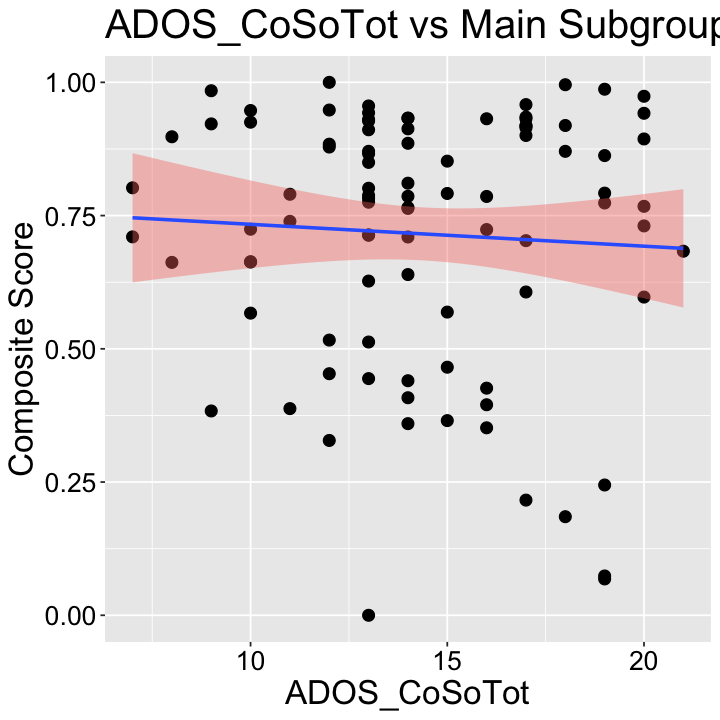

Saving 7 x 7 in image

Saving 7 x 7 in image



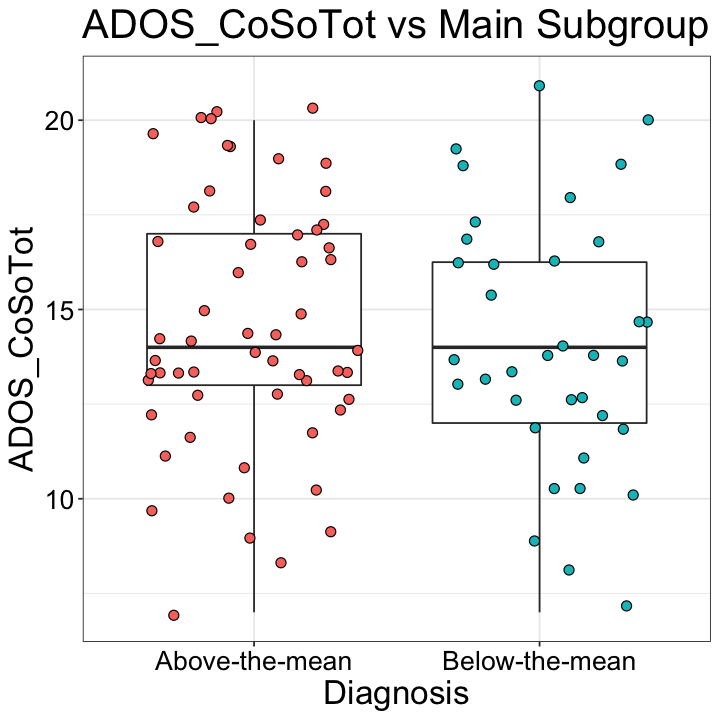

In [58]:
main_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_pheno_up.csv", row.names=1)
concensus_main = dataTandM$data$concensus[dataTandM$data$concensus$group=='main',]

concensus_main$final_ADOS_CoSoTot = main_pheno_up[concensus_main$sampleName, 'final_ADOS_CoSoTot']
concensus_main$recentDxJ_dxCode = main_pheno_up[concensus_main$sampleName, 'recentDxJ_dxCode']
concensus_main$recentDxJ_ageMo = main_pheno_up[concensus_main$sampleName, 'recentDxJ_ageMo']
concensus_main$subjectID = main_pheno_up[concensus_main$sampleName, 'subjectId']
head(concensus_main)
concensus_main$sampleLabel="TD"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="TD"]="TD"
# expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
print('mean')
print(mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"]))
the_mean = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
the_mean_td = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="TD"])
print(the_mean_td)

# the_mean = 0.75
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate>=the_mean]="Above-the-mean"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate<the_mean]="Below-the-mean"
write.table(concensus_main, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_consensus.csv",sep = ",")
# cor(, )

cor.test(concensus_main$weightedEstimate,concensus_main$final_ADOS_CoSoTot,use="complete.obs") 

inputPath = "/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs Main Subgroup")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.pdf"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.png"))
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"),width = 3.5, height = 4)


options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs Main Subgroup")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"))


In [106]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/out1/data.rda")
write.table(data[["testInputData"]]@phenoData@data, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno.csv",sep = ",")

concensus_test = dataTandM$data$concensus[dataTandM$data$concensus$group=='test',]
# head(concensus_test)

# test_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno_up.csv", row.names=1)
# concensus_test$final_ADOS_CoSoTot = test_pheno_up[concensus_test$sampleName, 'final_ADOS_CoSoTot']

# concensus_test$recentDxJ_dxCode = test_pheno_up[concensus_test$sampleName, 'recentDxJ_dxCode']
# concensus_test$recentDxJ_ageMo = test_pheno_up[concensus_test$sampleName, 'recentDxJ_ageMo']
# concensus_test$subjectID = test_pheno_up[concensus_test$sampleName, 'subjectId']
# # head(concensus_test)
# concensus_test$sampleLabel="TD"
# concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="TD"]="TD"
# # expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
# the_mean
# concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate>=the_mean]="Above-the-mean"
# concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate<the_mean]="Below-the-mean"

# write.table(concensus_test, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_consensus.csv",sep = ",", row.names=F)
# cor.test(concensus_test$weightedEstimate,concensus_test$final_ADOS_CoSoTot,use="complete.obs") 
# ###############


# # pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
# options(repr.plot.width = 6, repr.plot.height = 6)
# ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
#   geom_point(size=3)+
#   geom_smooth(method = "lm")+
#   labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
#   ggtitle("ADOS_CoSoTot vs Test Subgroup")+
#   theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# # dev.off()
# ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))
# ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"))

# # pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
# options(repr.plot.width = 6, repr.plot.height = 6)
# ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
#   geom_boxplot(outlier.shape = NA)+theme_bw()+
# geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
# ggtitle("ADOS_CoSoTot vs Test Subgroup")+
# theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# # dev.off()
# ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.png"))
# ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"))


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



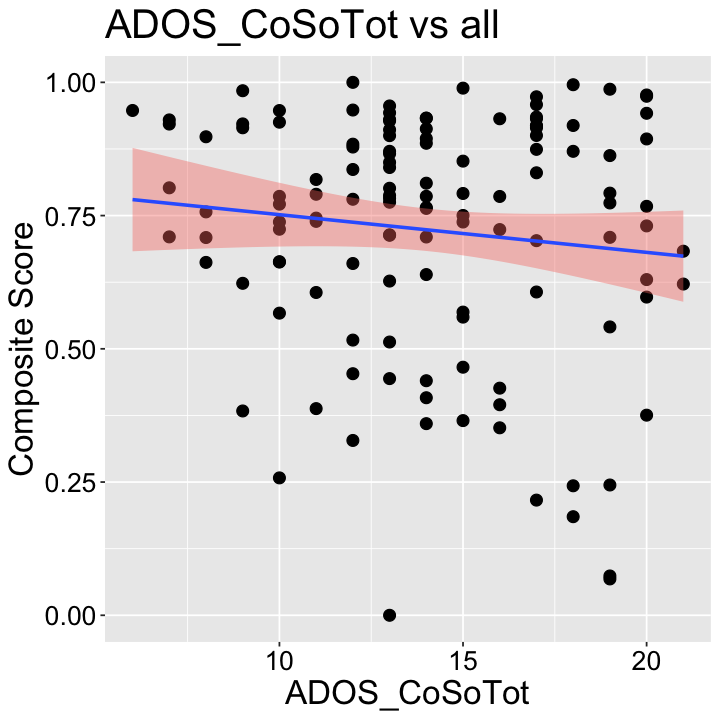

Saving 7 x 7 in image

Saving 7 x 7 in image



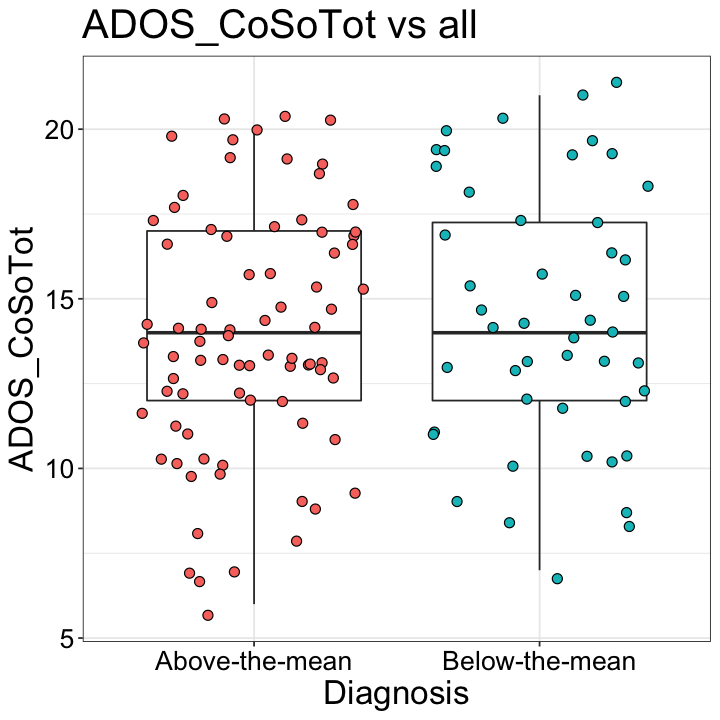

In [27]:
concensus_all=rbind(concensus_main, concensus_test)
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs all")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))

# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs all")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.pdf"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.png"))

In [28]:
round(quantile(dataTandM$data$concensus[dataTandM$data$concensus$real==1 & dataTandM$data$concensus$group=='test', 'weightedEstimate']),4)
round(quantile(dataTandM$data$concensus[dataTandM$data$concensus$real==0 & dataTandM$data$concensus$group=='test', 'weightedEstimate']),4)

round(quantile(dataTandM$data$concensus[dataTandM$data$concensus$real==1 & dataTandM$data$concensus$group=='main', 'weightedEstimate']),4)
round(quantile(dataTandM$data$concensus[dataTandM$data$concensus$real==0 & dataTandM$data$concensus$group=='main', 'weightedEstimate']),4)


0%    25%    50%    75%   100% 
0.2430 0.6375 0.7642 0.8895 0.9891

0%    25%    50%    75%   100% 
0.0034 0.2417 0.4376 0.5715 0.7274

0%    25%    50%    75%   100% 
0.0000 0.5971 0.7859 0.9147 1.0000

0%    25%    50%    75%   100% 
0.0056 0.1342 0.2616 0.4908 0.9997

[1] 0.7156527

[1] 0.7156527


Saving 7 x 7 in image

Saving 7 x 7 in image



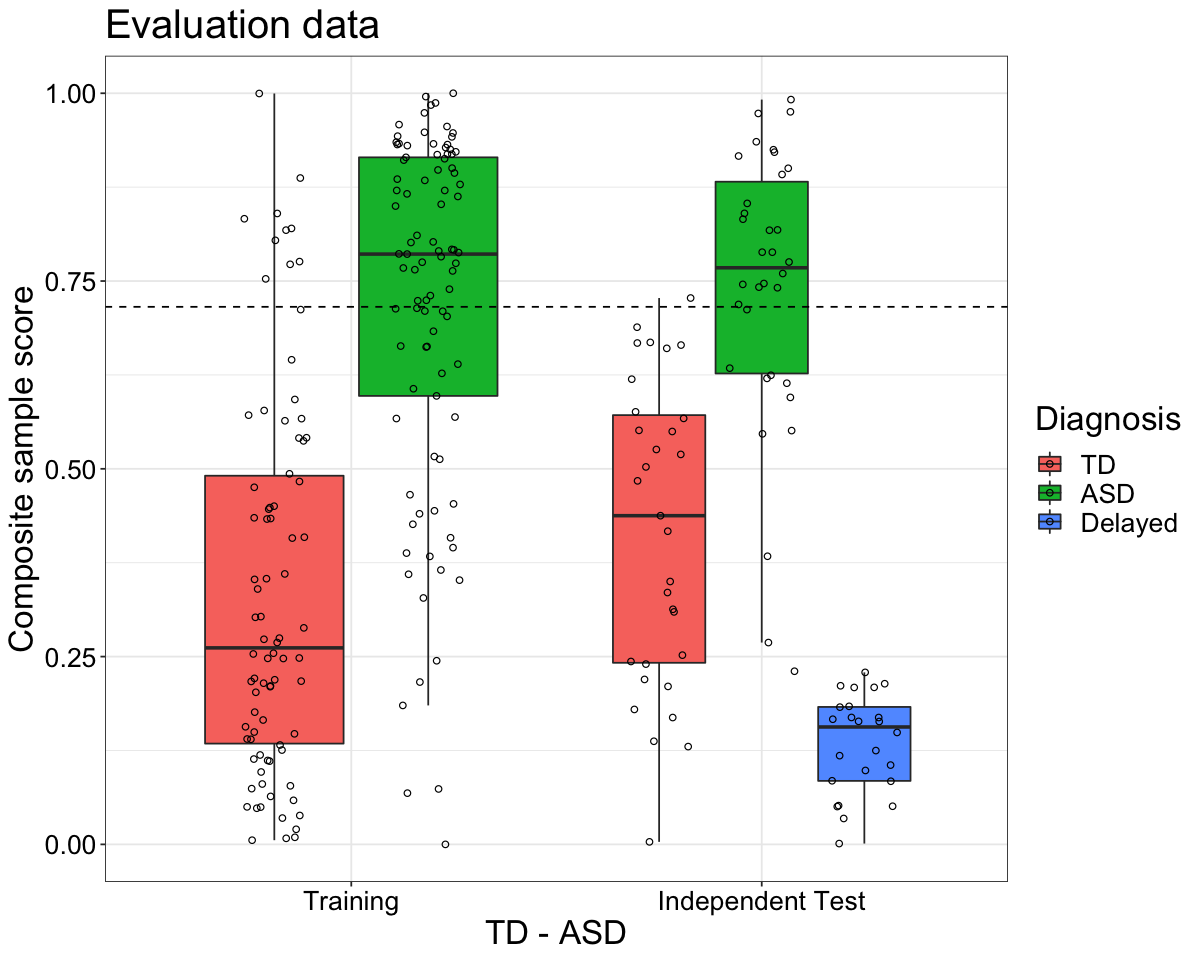

In [64]:
the_lint = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
the_lint
print(the_lint)
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+
  geom_boxplot(outlier.shape = NA)+
  theme_bw()+geom_hline(yintercept = the_lint,linetype='dashed')+
  # geom_jitter(width = 0.2, alpha=0.6, shape=21)+
  geom_point(position=position_jitterdodge(dodge.width=0.75), shape=1)+
  ggtitle("Evaluation data")+
  theme( axis.text = element_text(color="black"), text = element_text(size = 20))+
  labs(x="TD - ASD",  y="Composite sample score")+
  scale_fill_discrete(name='Diagnosis', labels=c('TD', 'ASD', 'Delayed'))+
  scale_x_discrete(labels=c("Training", "Independent Test"))

ggsave(paste0(inputPath, "Figure2_c.pdf"))
ggsave(paste0(inputPath, "Figure2_c.png"))

In [ ]:
the_lint = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
the_lint
print(the_lint)
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+
  geom_boxplot(outlier.shape = NA)+
  theme_bw()+geom_hline(yintercept = the_lint,linetype='dashed')+
  # geom_jitter(width = 0.2, alpha=0.6, shape=21)+
  geom_point(position=position_jitterdodge(dodge.width=0.75), shape=1)+
  ggtitle("Evaluation data")+
  theme(legend.position = "right", axis.text = element_text(color="black"), text = element_text(size = 20))+
  labs(x="TD - ASD",  y="Composite sample score")+
  scale_fill_discrete(name='Diagnosis', labels=c('TD','ASD'))+
  scale_x_discrete(labels=c("Discovery", "Independent"))

ggsave(paste0(inputPath, "Figure2_c.pdf"))
ggsave(paste0(inputPath, "Figure2_c.png"))
data.to_csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/ld_td_asd.csv")

In [30]:
the_output_table = dataTandM$data$concensus
# sum(the_output_table[the_output_table$real == 1,]$weightedEstimate>0.714)
sum(the_output_table[the_output_table$real == 1 & the_output_table$group == 'main',]$weightedEstimate<=the_lint)
sum(the_output_table[the_output_table$real == 1 & the_output_table$group == 'main',]$weightedEstimate>=the_lint)
nrow(the_output_table[the_output_table$real == 0 & the_output_table$group == 'main',])
# sum(the_output_table[the_output_table$real == 0,]$weightedEstimate>0.714)
# sum(the_output_table[the_output_table$real == 0,]$weightedEstimate<=0.714)

82/(82+45)
11/(11+102)
# sum(the_output_table[the_output_table$group =='main',]$weightedEstimate>0.714)

[1] 36

[1] 57

[1] 82

[1] 0.6456693

[1] 0.09734513

In [31]:
write.table(dataTandM$data$concensus, paste0(inputPath, 'main_test_ensemble_score.csv'), sep=",")
# write.table(dataTandM$data$concensus, paste0(inputPath, 'main_test_ensemble_score.csv'), sep=",")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



pdf 
  2

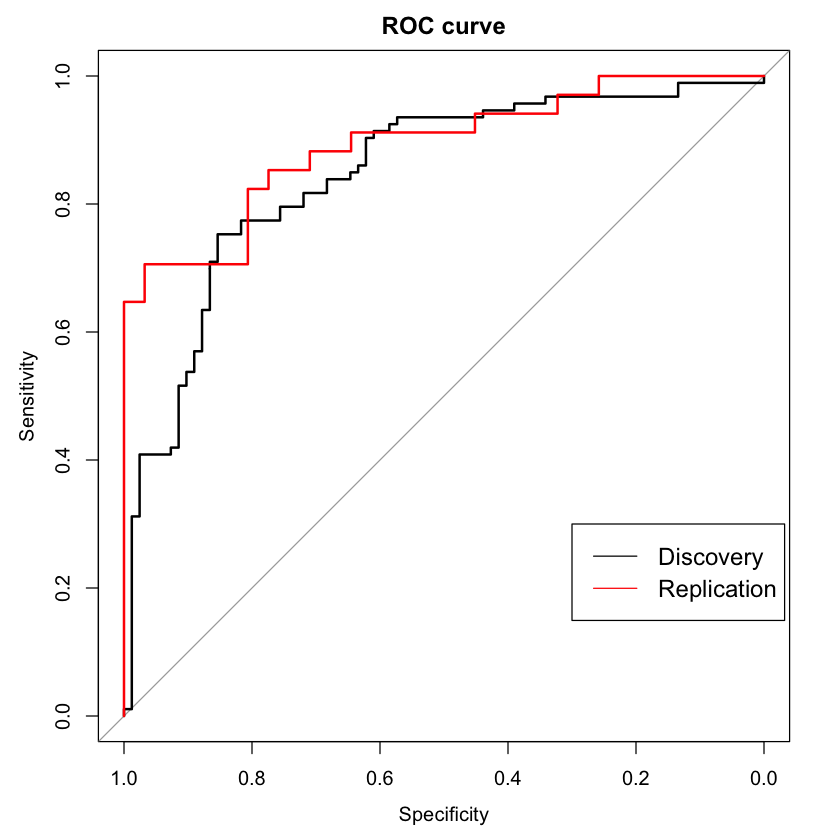

In [32]:
#AU-ROC of the composite scores
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis=.myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)
options(repr.plot.width = 7, repr.plot.height = 7)
plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Discovery", "Replication"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
options(repr.plot.width = 6, repr.plot.height = 6)

pdf(file=paste0(inputPath,"figroc_curve.pdf"))
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis = .myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)

plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Discovery", "Replication"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
dev.off()

# Add the analysis of the age

In [33]:
library(readxl)
age_test <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/manuscripts/TestPheno_with_BDAge_updated.xlsx")
age_main <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/manuscripts/MainPheno_with_BDAge_updated.xlsx")
age_ld = read_csv("/Volumes/Work/Vahid_work/classification_newcode_data/pheno_long.csv")


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ───────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  subjectId = col_character(),
  blooddrawid = col_character(),
  age = col_double(),
  recentDx_EvalDate = col_character(),
  diagnosis_binary = col_character(),
  diagnosis_multi1 = col_character(),
  batch = col_character(),
  sex = col_character(),
  Neutrophil = col_double(),
  Tcell = col_double(),
  Monocyte = col_double(),
  Bcell = col_double(),
  NKcell = col_double(),
  PlasmaCell = col_double(),
  DendriticCell = col_double()
)




In [34]:
age_main

X,subjectId,blooddrawid,age,recentDx_EvalDate,diagnosis_binary,diagnosis_multi1,batch,sex,Neutrophil,Tcell,Monocyte,Bcell,NKcell,PlasmaCell,DendriticCell,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,age_at_blooddraw
<chr>,<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
4807135042_B,A2H7X,239-01,22.899,2008-11-07,ASD,PDDNOS,WG6,M,-0.036208737,0.034645468,-0.031791137,0.014287607,0.031658445,-0.001823151,-0.024369144,10,ASD,22.899,22
223,A2Y4H,576-01,35.483,2010-04-26,ASD,PDDNOS,1,M,0.007827978,-0.004516273,0.018506445,0.026278674,-0.020799085,-0.049248118,-0.034710308,10,ASD,35.483,35
363,A9P5P,837-01,47.376,2013-12-11,TD,TD,1,M,-0.044215634,0.054873321,-0.070568563,0.043028075,-0.003206320,0.033453652,-0.006597534,2,TD,47.376,16
135,B2J9W,429-01,34.760,2011-02-17,ASD,ASD,1,M,-0.049209288,0.050637396,0.005405099,0.023745279,0.037970833,0.012079845,-0.039781150,13,ASD,34.760,17
168,B4C2A,478-01,31.540,2011-06-20,TD,PrevLDDTyp,1,M,0.026765188,0.005010205,-0.010309037,0.045445462,-0.018474819,0.000261536,-0.011606193,5,TD,31.540,12
4807135024_E,B4J4L,305-01,44.715,2010-06-05,TD,TD,WG6,M,-0.038475107,0.050398684,-0.004388469,-0.013867581,-0.092020776,-0.009792974,-0.041630180,2,TD,44.715,28
275,B4V3N,668-01,31.639,2010-09-02,ASD,ASD,1,M,-0.059157144,0.046957104,-0.082743075,0.048691132,0.011423116,0.059760254,-0.004638912,13,ASD,31.639,31
203,B5Z4P,533-01,37.027,2012-01-30,TD,TD,1,M,-0.014392986,-0.013345668,-0.013027751,0.028414944,0.044921301,0.061370562,0.007576430,4,TD,37.027,13
241,B8T5A,614-01,84.534,2015-01-05,ASD,ASD,1,M,-0.059358017,0.037087239,-0.052365408,0.002400259,0.081993281,-0.003238903,-0.021762718,13,ASD,84.534,29


In [35]:
merge_age_main = merge(concensus_main, age_main, by.x="subjectID", by.y="subjectId")
merge_age_main = merge_age_main[, c('subjectID','weightedEstimate', 'age_at_blooddraw', 'sampleLabel', 'recentDxJ_dxCode.x','blooddrawid')]
merge_age_test = merge(concensus_test, age_test, by.x="subjectID", by.y="subjectId")
merge_age_test = merge_age_test[, c('subjectID','weightedEstimate', 'age_at_blooddraw', 'sampleLabel', 'recentDxJ_dxCode.x','blooddrawid')]
merge_age_test = transform(merge_age_test, age_at_blooddraw = as.numeric(age_at_blooddraw))
merge_age_main = transform(merge_age_main, age_at_blooddraw = as.numeric(age_at_blooddraw))
merged_long = merge(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("TD"),],age_ld[,c("subjectId", "age",'blooddrawid')], by.x="subjectID", by.y='subjectId', all=FALSE)
merged_long = distinct(merged_long)
for(i in merged_long$subjectID){
    merge_age_main[merge_age_main$subjectID==i, 'age_at_blooddraw']=merged_long[merged_long$subjectID==i,'age']}
a = rbind(merge_age_main, merge_age_test)
a
# a = transform(a, age_at_blooddraw = as.numeric(age_at_blooddraw))

Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”


subjectID,weightedEstimate,age_at_blooddraw,sampleLabel,recentDxJ_dxCode.x,blooddrawid
<fct>,<dbl>,<dbl>,<chr>,<fct>,<chr>
A2H7X,0.72441834,22.00,Above-the-mean,ASD,239-01
A2Y4H,0.92522990,35.00,Above-the-mean,ASD,576-01
A9P5P,0.35278578,16.00,TD,TD,837-01
B2J9W,0.71380219,17.00,Below-the-mean,ASD,429-01
B4C2A,0.07797540,12.00,TD,TD,478-01
B4J4L,0.43382274,28.00,TD,TD,305-01
B4V3N,0.62710652,31.00,Below-the-mean,ASD,668-01
B5Z4P,0.04811835,13.00,TD,TD,533-01
B8T5A,0.87061006,29.00,Above-the-mean,ASD,614-01


In [36]:
merged_long

subjectID,weightedEstimate,age_at_blooddraw,sampleLabel,recentDxJ_dxCode.x,blooddrawid.x,age,blooddrawid.y
<fct>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<dbl>,<chr>
C2F2C,0.14719250,13,TD,TD,699-01,13.240,699-01
G8M7A,0.36006641,36,TD,TD,532-01,36.172,532-01
J4G6T,0.21087291,44,TD,TD,518-01,44.616,518-01
J4Z9D,0.25352084,15,TD,TD,100-01,34.267,374
J7F8X,0.33997869,23,TD,TD,448-01,23.754,448-01
K4X5H,0.88713424,13,TD,TD,113-01,20.895,113-01
K9S3V,0.20996155,24,TD,TD,114-01,30.423,202-01
P6C6P,0.25449887,12,TD,TD,172-01,44.517,357
R6P4Y,0.83996482,33,TD,TD,376-01,33.906,165-01


In [37]:
merge(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("TD"),],age_ld[,c("subjectId", "age")], by.x="subjectID", by.y='subjectId', all=FALSE)

subjectID,weightedEstimate,age_at_blooddraw,sampleLabel,recentDxJ_dxCode.x,blooddrawid,age
<fct>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<dbl>
C2F2C,0.14719250,13.240,TD,TD,699-01,13.240
G8M7A,0.36006641,36.172,TD,TD,532-01,36.172
J4G6T,0.21087291,44.616,TD,TD,518-01,44.616
J4Z9D,0.25352084,34.267,TD,TD,100-01,34.267
J7F8X,0.33997869,23.754,TD,TD,448-01,23.754
K4X5H,0.88713424,20.895,TD,TD,113-01,20.895
K4X5H,0.88713424,20.895,TD,TD,113-01,20.895
K9S3V,0.20996155,30.423,TD,TD,114-01,30.423
P6C6P,0.25449887,44.517,TD,TD,172-01,44.517


In [40]:
q=ggplot(a[a$recentDxJ_dxCode %in% c("TD",'ASD'),],aes(x=as.numeric(age_at_blooddraw), y=weightedEstimate, color=recentDxJ_dxCode.x))+
#    geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Age", y='Composite score')+
  geom_smooth(method = "lm")+
  geom_jitter(width = 1, alpha=0.6)+
#   ggtitle("Composite score vs geo-fixation percentage")+
#   geom_hline(yintercept = the_mean,linetype='dashed')+
#   geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
# ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))

ggsave(plot = q, width = 10, height = 6, dpi = 300, filename = paste0(inputPath,"td_with_asd.pdf"))


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [45]:
a[a$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw

[1] 22 35 17 31 29 13 41 19 21 26 25 40 25 30 32 22 26 40 41 30 40 26 23 31 19
 [26] 22 22 37 26 25 30 27 41 24 36 33 NA 25 24 19 35 23 27 19 15 14 49 25 41 29
 [51] 32 24 27 39 31 26 43 30 33 40 20 31 33 22 21 28 37 30 22 35 18 13 19 12 24
 [76] 41 34 31 19 14 30 26 35 23 28 19 39 21 18 34 24 30 30 14 31 35 29 15 29 19
[101] 30 18 18 28 31 41 40 40 12 34 25 40 29 33 29 39 33 12 28 15 16 31 41 38 36
[126] 33 NA

In [52]:
mean(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, na.rm = TRUE)
sd(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, na.rm = TRUE)
mean(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, na.rm = TRUE)
sd(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, na.rm = TRUE)
t.test(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw,merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw,na.rm=TRUE )

[1] 27.80435

[1] 7.993458

[1] 21.34413

[1] 9.375178


	Welch Two Sample t-test

data:  merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("ASD"),  and merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("TD"),     ]$age_at_blooddraw and     ]$age_at_blooddraw
t = 4.8607, df = 160.13, p-value = 2.769e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.835474 9.084954
sample estimates:
mean of x mean of y 
 27.80435  21.34413 


In [54]:
mean(merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, na.rm = TRUE)
sd(merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, na.rm = TRUE)
mean(merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, na.rm = TRUE)
sd(merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, na.rm = TRUE)
t.test(merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw,merge_age_test[merge_age_test$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw,na.rm=TRUE )

[1] 28.54545

[1] 9.219853

[1] 16.5

[1] 3.963193


	Welch Two Sample t-test

data:  merge_age_test[merge_age_test$recentDxJ_dxCode %in% c("ASD"),  and merge_age_test[merge_age_test$recentDxJ_dxCode %in% c("TD"),     ]$age_at_blooddraw and     ]$age_at_blooddraw
t = 6.8419, df = 44.31, p-value = 1.884e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.498025 15.592884
sample estimates:
mean of x mean of y 
 28.54545  16.50000 


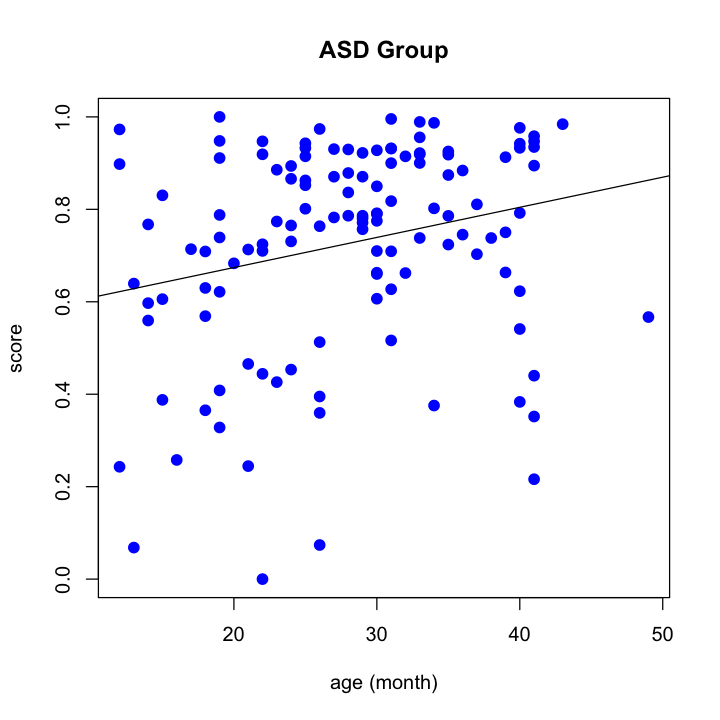

[1] NA


Call:
lm(formula = "weightedEstimate~age_at_blooddraw", data = merge_age_main[merge_age_main$recentDxJ_dxCode %in% 
    c("ASD"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68655 -0.11645  0.06043  0.16199  0.33147 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.554375   0.087835   6.312 1.02e-08 ***
age_at_blooddraw 0.006008   0.003037   1.978    0.051 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2316 on 90 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.04166,	Adjusted R-squared:  0.03101 
F-statistic: 3.913 on 1 and 90 DF,  p-value: 0.05098


Warning message in cor.test.default(merge_age_main[merge_age_main$recentDxJ_dxCode %in% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("ASD"),  and merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("ASD"),     ]$age_at_blooddraw and     ]$weightedEstimate
S = 96606, p-value = 0.01395
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2555356 


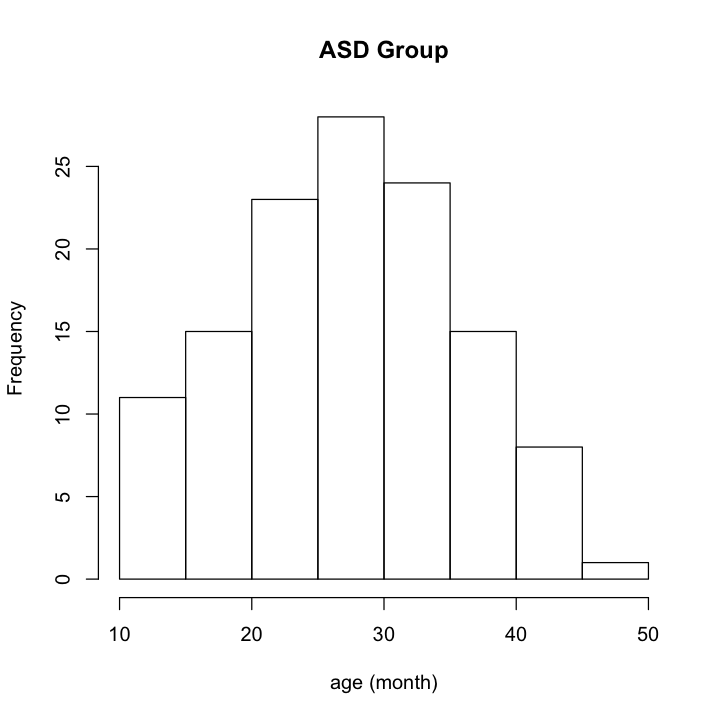

In [41]:
plot(x=a[a$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, y=a[a$recentDxJ_dxCode %in% c('ASD'),]$weightedEstimate, pch = 16, cex = 1.3, col = "blue", main = "ASD Group", xlab = "age (month)", ylab = "score")
abline(lm("weightedEstimate~age_at_blooddraw", a[a$recentDxJ_dxCode %in% c("ASD"),]))
hist(a[a$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw, main = "ASD Group", xlab = "age (month)")
summary(lm("weightedEstimate~age_at_blooddraw", merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]))
cor.test(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]$age_at_blooddraw,
         merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('ASD'),]$weightedEstimate, 
         method = "spearman")

In [107]:
pdf(file="saving_plot4.pdf")
plot(x=a[a$recentDxJ_dxCode %in% c('TD')&a$age_at_blooddraw>12,]$age_at_blooddraw, y=a[a$recentDxJ_dxCode %in% c('TD') & a$age_at_blooddraw>12,]$weightedEstimate, pch = 16, cex = 1.3, col = "blue", main = "TD Group", xlab = "age (month)", ylab = "score")
abline(lm("weightedEstimate~age_at_blooddraw", a[a$recentDxJ_dxCode %in% c('TD') & a$age_at_blooddraw>12,]))
hist(a[a$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, main = "TD Group", xlab = "age (month)")
dev.off()
cor.test(a[a$recentDxJ_dxCode %in% c('TD')& a$age_at_blooddraw>12,]$age_at_blooddraw,
         a[a$recentDxJ_dxCode %in% c('TD')& a$age_at_blooddraw>12,]$weightedEstimate, 
         method = "spearman")

pdf 
  2

Warning message in cor.test.default(a[a$recentDxJ_dxCode %in% c("TD") & a$age_at_blooddraw > :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  a[a$recentDxJ_dxCode %in% c("TD") & a$age_at_blooddraw > 12,  and a[a$recentDxJ_dxCode %in% c("TD") & a$age_at_blooddraw > 12,     ]$age_at_blooddraw and     ]$weightedEstimate
S = 122725, p-value = 0.0314
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2175588 


In [155]:
merge_age_main

subjectID,weightedEstimate,age_at_blooddraw,sampleLabel,recentDxJ_dxCode.x,blooddrawid
<fct>,<dbl>,<dbl>,<chr>,<fct>,<chr>
A2H7X,0.72441834,22.00,Above-the-mean,ASD,239-01
A2Y4H,0.92522990,35.00,Above-the-mean,ASD,576-01
A9P5P,0.35278578,16.00,TD,TD,837-01
B2J9W,0.71380219,17.00,Below-the-mean,ASD,429-01
B4C2A,0.07797540,12.00,TD,TD,478-01
B4J4L,0.43382274,28.00,TD,TD,305-01
B4V3N,0.62710652,31.00,Below-the-mean,ASD,668-01
B5Z4P,0.04811835,13.00,TD,TD,533-01
B8T5A,0.87061006,29.00,Above-the-mean,ASD,614-01



Call:
lm(formula = "weightedEstimate~age_at_blooddraw*recentDxJ_dxCode.x", 
    data = GG)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6865 -0.1692  0.0318  0.1621  0.6213 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            0.554375   0.090484   6.127 6.05e-09 ***
age_at_blooddraw                       0.006008   0.003129   1.920  0.05652 .  
recentDxJ_dxCode.xTD                  -0.372518   0.111911  -3.329  0.00107 ** 
age_at_blooddraw:recentDxJ_dxCode.xTD  0.001270   0.004217   0.301  0.76360    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2386 on 170 degrees of freedom
Multiple R-squared:  0.4193,	Adjusted R-squared:  0.409 
F-statistic: 40.92 on 3 and 170 DF,  p-value: < 2.2e-16


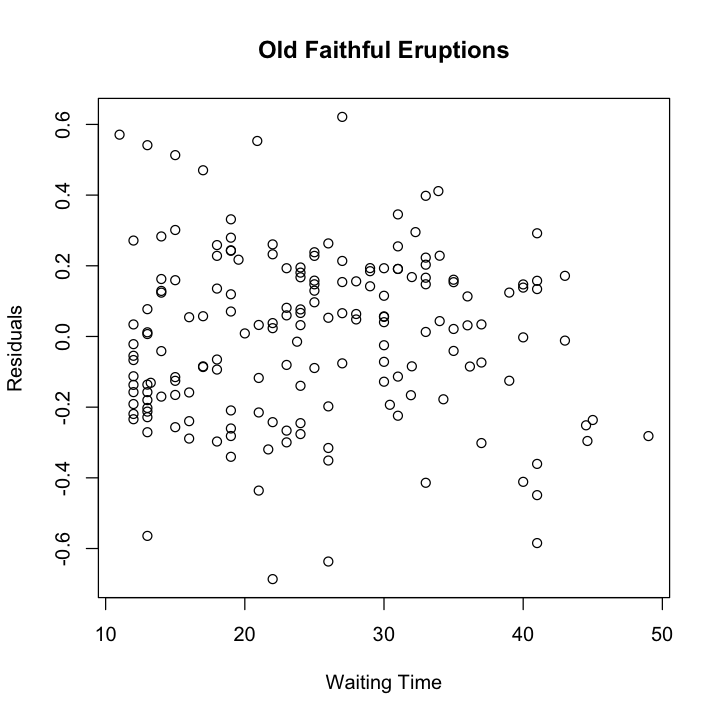

In [205]:
GG=na.omit(merge_age_main[merge_age_main$recentDxJ_dxCode.x %in% c('ASD', 'TD'),])
b=lm("weightedEstimate~age_at_blooddraw*recentDxJ_dxCode.x",data=GG)
summary(b)
# plot(density(resid(b, type='response')))
# eruption.res = resid(eruption.lm)

plot(GG$age_at_blooddraw, b$residuals, 
     ylab="Residuals", xlab="Waiting Time", 
     main="Old Faithful Eruptions") 
# > abline(0, 0)            

In [198]:
install.packages("jtools")
library('jtools')


The downloaded binary packages are in
	/var/folders/r7/f70_k76n3sv5hl_s70c_cb4w0000gn/T//Rtmp15yVPc/downloaded_packages


In [203]:
# library(ggplot2)
# data(mpg)
a = glm("weightedEstimate~age_at_blooddraw*recentDxJ_dxCode.x", family=quasipoisson, data=GG)
# plot(density(resid(a, type='response')))
# plot(GG$age_at_blooddraw, a$residuals, 
#      ylab="Residuals", xlab="Waiting Time", 
#      main="Old Faithful Eruptions") 
effect_plot(a, pred = age_at_blooddraw*recentDxJ_dxCode.x, interval = TRUE,plot.points = TRUE)

# > abline(0, 0)            

ERROR: Error: [31mThe variable(s) age_at_blooddraw * recentDxJ_dxCode.x were not found in the
data.[39m


In [146]:
?lm

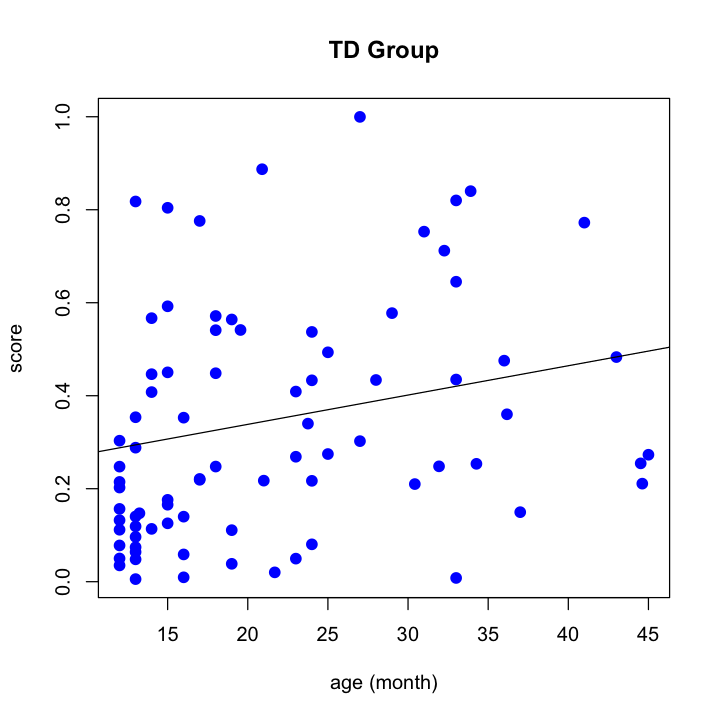

null device 
          1

Warning message in cor.test.default(merge_age_main[merge_age_main$recentDxJ_dxCode %in% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("TD") &  and merge_age_main[merge_age_main$recentDxJ_dxCode %in% c("TD") &     merge_age_main$age_at_blooddraw > 12, ]$age_at_blooddraw and     merge_age_main$age_at_blooddraw > 12, ]$weightedEstimate
S = 41954, p-value = 0.01203
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2965491 


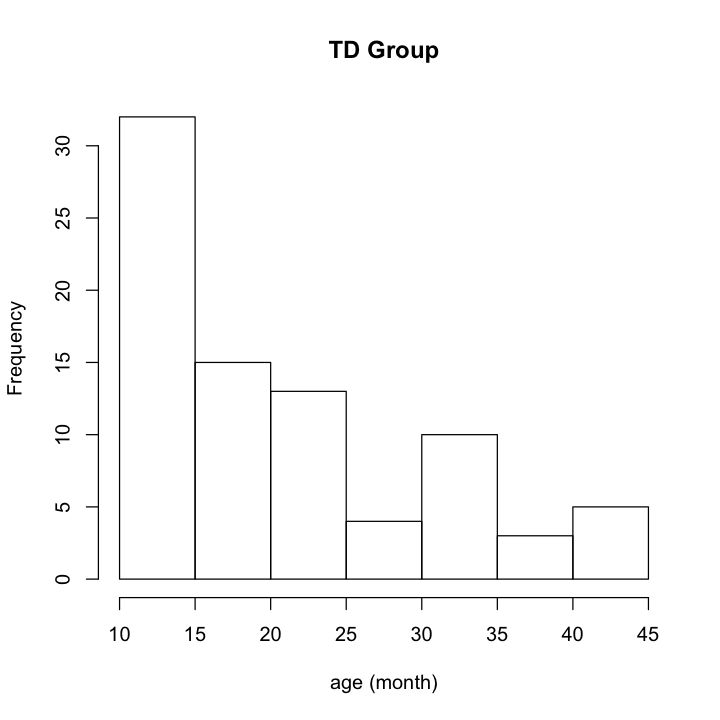

In [123]:
plot(x=merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD')& merge_age_main$age_at_blooddraw>11,]$age_at_blooddraw, y=merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD') & merge_age_main$age_at_blooddraw>11,]$weightedEstimate, pch = 16, cex = 1.3, col = "blue", main = "TD Group", xlab = "age (month)", ylab = "score")
abline(lm("weightedEstimate~age_at_blooddraw", merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD') & merge_age_main$age_at_blooddraw>12,]))
hist(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD'),]$age_at_blooddraw, main = "TD Group", xlab = "age (month)")
dev.off()
# cor.test(merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD')& merge_age_main$age_at_blooddraw>12,]$age_at_blooddraw,
#          merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD')& merge_age_main$age_at_blooddraw>12,]$weightedEstimate, 
#          method = "spearman")


In [126]:
summary(lm("weightedEstimate~age_at_blooddraw", merge_age_main[merge_age_main$recentDxJ_dxCode %in% c('TD') & merge_age_main$age_at_blooddraw>12,]))


Call:
lm(formula = "weightedEstimate~age_at_blooddraw", data = merge_age_main[merge_age_main$recentDxJ_dxCode %in% 
    c("TD") & merge_age_main$age_at_blooddraw > 12, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4124 -0.1906 -0.0803  0.1780  0.6171 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)      0.212255   0.079392   2.674  0.00936 **
age_at_blooddraw 0.006310   0.003229   1.954  0.05477 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2499 on 69 degrees of freedom
Multiple R-squared:  0.05243,	Adjusted R-squared:  0.0387 
F-statistic: 3.818 on 1 and 69 DF,  p-value: 0.05477


In [130]:
lm_asd = lm("weightedEstimate~age_at_blooddraw", a[a$recentDxJ_dxCode %in% c("ASD"),])
summary(lm_asd)


Call:
lm(formula = "weightedEstimate~age_at_blooddraw", data = a[a$recentDxJ_dxCode %in% 
    c("ASD"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68711 -0.08193  0.05075  0.15419  0.35095 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.543740   0.068831   7.900 1.34e-12 ***
age_at_blooddraw 0.006517   0.002358   2.764  0.00658 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.218 on 123 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.05849,	Adjusted R-squared:  0.05084 
F-statistic: 7.641 on 1 and 123 DF,  p-value: 0.006583


In [108]:
lm_td = lm("weightedEstimate~age_at_blooddraw", a[a$recentDxJ_dxCode %in% c("TD"),])
summary(lm_td)


Call:
lm(formula = "weightedEstimate~age_at_blooddraw", data = a[a$recentDxJ_dxCode %in% 
    c("TD"), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43155 -0.19198 -0.04964  0.18975  0.59827 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.229584   0.057594   3.986 0.000121 ***
age_at_blooddraw 0.006364   0.002645   2.406 0.017794 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2379 on 110 degrees of freedom
Multiple R-squared:   0.05,	Adjusted R-squared:  0.04136 
F-statistic: 5.789 on 1 and 110 DF,  p-value: 0.01779


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


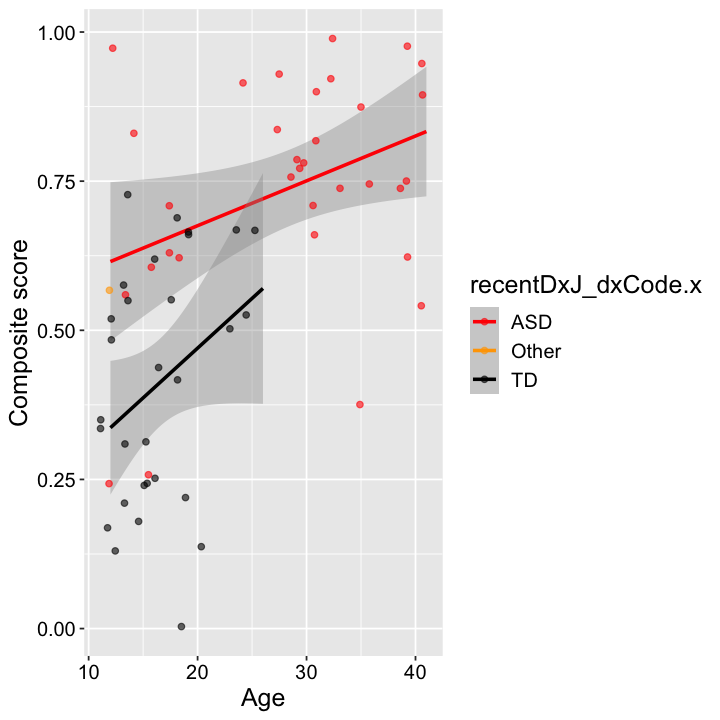

In [124]:
ggplot(merge_age_test,aes(x=as.numeric(age_at_blooddraw), y=weightedEstimate, color=recentDxJ_dxCode.x))+
#    geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Age", y='Composite score')+
  geom_smooth(method = "lm")+
  geom_jitter(width = 1, alpha=0.6)+
#   ggtitle("Composite score vs geo-fixation percentage")+
#   geom_hline(yintercept = the_mean,linetype='dashed')+
#   geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
# ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))
# ggsave(plot = q, width = 8, height = 6, dpi = 300, filename = paste0(inputPath,"test_age.pdf"))


In [118]:
q = ggplot(a[a$recentDxJ_dxCode %in% c("ASD"),],aes(x=as.numeric(age_at_blooddraw), y=weightedEstimate, color=recentDxJ_dxCode.x))+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Age", y='Composite score')+
  geom_smooth(method = "lm")+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
# ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))
ggsave(plot = q, width = 8, height = 6, dpi = 300, filename = paste0(inputPath,"main_age.pdf"))


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [89]:
inputPath

[1] "/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


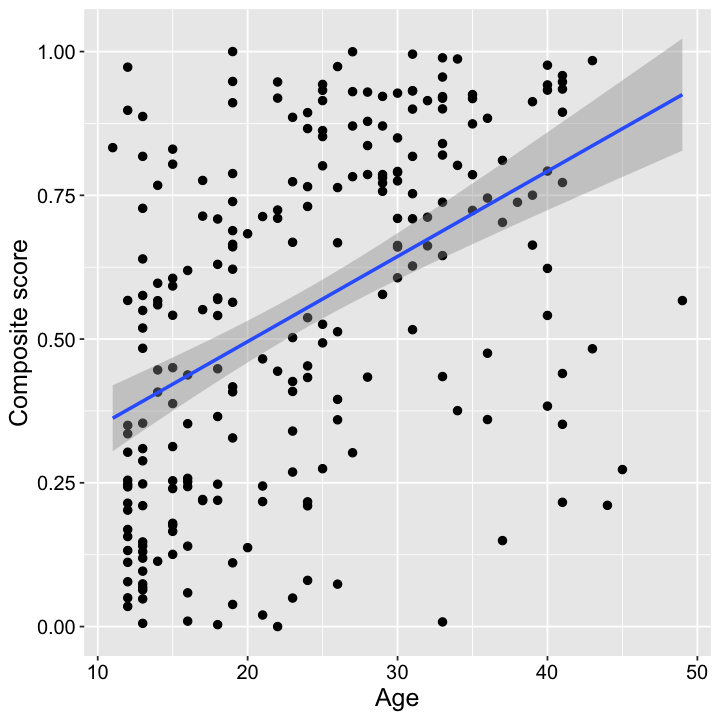

In [85]:
ggplot(a,aes(x=as.numeric(age_at_blooddraw), y=weightedEstimate))+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Age", y='Composite score')+
  geom_smooth(method = "lm")+

#   ggtitle("Composite score vs geo-fixation percentage")+
#   geom_hline(yintercept = the_mean,linetype='dashed')+
#   geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
# ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))

In [62]:
age_main[which(age_main$subjectId==concensus_main$subjectID),]

X,subjectId,blooddrawid,age,recentDx_EvalDate,diagnosis_binary,diagnosis_multi1,batch,sex,Neutrophil,Tcell,Monocyte,Bcell,NKcell,PlasmaCell,DendriticCell,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,age_at_blooddraw
<chr>,<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
124,C5V2N,408,31.409,2011-03-11,TD,TD,1,M,-0.02042536,0.0444229,-0.01740764,0.042641224,-0.03297520,0.01997867,-0.03676298,1,TD,31.409,12
193,J4G6T,518-01,45.043,2010-02-18,TD,TD,1,M,0.07175497,-0.0340770,0.02906040,0.002576874,-0.01243107,-0.05868495,-0.02951106,0,TD,45.043,44


In [ ]:
score_main = read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/manuscripts/TestPheno_with_BDAge_updated.xlsx")
score_test = 

### Prenatal event

In [34]:
library(readxl)
my_data_1 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_mainConsensus_subjects.xlsx")
my_data_2 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_testConsensus_subjects.xlsx")

In [35]:
head(my_data_1)

FormSerialId,EvalDate,SubjectId,P2F2,DOB,AgeMo,Sex,PregProb,FertDrugsNY,FertDrugs,⋯,UnusExpln,BrthWt_lb,BrthWt_oz,BrthLen_in,BrthHC_cm,Apgar1min,Apgar5min,HospStay,Prob1stMosNY,Prob1stMosExp
<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PNB-00006,39584,R8S6F,MASI,2005-11-02,30.422999999999998,M,N,N,NULL,⋯,NULL,9,4,20,NULL,NULL,NULL,3,Y,Many colds- 2 yr old brother at home.
PNB-00009,39688,S4X9Y,ZEHU,2007-04-05,16.789000000000001,M,N,N,NULL,⋯,C-section after pushing for 3 hours. He wasn't in the birth canal straight+ got fever.,7,14,19,14,NULL,NULL,2,Y,"Jaundice, but not too bad. We didn't need to use the light."
PNB-00014,39549,E6E9P,CORE,2005-10-20,29.7,M,N,N,NULL,⋯,NULL,NULL,22,NULL,NULL,NULL,NULL,NULL,Y,"Jaundice, fever, weight loss, later developed laryngomalacia and birth mark like rash on R cheek"
PNB-00015,39834,Q2P7E,SALA,2007-08-14,17.280999999999999,M,-,-,NULL,⋯,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,-,NULL
PNB-00016,39541,M4L5B,MASA,2006-09-08,18.824999999999999,M,Y,Y,Injectable and cloned,⋯,NULL,6,14,20,NULL,8,9,3,N,NULL
PNB-00017,39825,P8M2M,OLHO,2006-10-31,26.414999999999999,M,Y,Y,IVF,⋯,please see NICU d/c summary,6,5,49.5,34,6,8,3,Y,NULL


In [36]:
head(concensus_main)

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID,sampleLabel
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>,<chr>
2,101,0.7736704,1,main,19,ASD,34.366,X3F5T,Above-the-mean
6,106,0.3833862,1,main,9,ASD,40.542,H3E8D,Below-the-mean
7,107,0.3280603,1,main,12,ASD,120.000,C2K6H,Below-the-mean
8,109,0.5667895,0,main,2,TD,34.825,Y2P2Z,TD
9,110,0.4502608,0,main,1,TD,15.244,H7U8Q,TD
10,111,0.9109924,1,main,13,ASD,30.292,M8K5X,Above-the-mean


In [39]:
prenatal = rbind(my_data_1, my_data_2)
# prenatal = my_data_1

the_mean = mean(concensus_main[concensus_main$recentDxJ_dxCode=="ASD",]$weightedEstimate)
# the_mean
# the_mean =0.74
sum(concensus_main$weightedEstimate>the_mean & concensus_main$real==0)
bloodId=concensus_main$sampleName
sampleNames=concensus_main$subjectID
scores=concensus_main$weightedEstimate
DX=concensus_main$real
df=data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F)
rm(sampleNames,scores,DX)
bloodId=concensus_test$sampleName
sampleNames=concensus_test$subjectID
scores=concensus_test$weightedEstimate
DX=concensus_test$real
df=rbind(df,data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F))

dim(df)

df=merge(df, prenatal, by.x="sampleNames", by.y="SubjectId")
df$category="other"
df$category[df$dx==0]="TD"
df$category[df$dx==1&df$scores>=the_mean]="above"
df$category[df$dx==1&df$scores<the_mean]="below"

# df=my_data_3
# df = as.data.frame(df)
# table(df$LocAnes)
df$Hosp_tri=gsub("-",NA,df$Hosp_tri)
df$Hosp_tri = gsub("NULL",NA,df$Hosp_tri)
df$Hosp_med=gsub("-",NA,df$Hosp_med)
df$Hosp_med = gsub("NULL",NA,df$Hosp_med)
df$Surgery_tri=gsub("-",NA,df$Surgery_tri)
df$Surgery_tri = gsub("NULL",NA,df$Surgery_tri)

df$Surgery_med[which(df$Surgery_med=="C-section")]=NA
df$Surgery_med[which(df$Surgery_med=="c-section, vicadin (2 weeks)")]=NA
df$Surgery_med=gsub("-",NA,df$Surgery_med)
df$Surgery_med = gsub("NULL",NA,df$Surgery_med)

df$WtLoss_tri=gsub("-",NA,df$WtLoss_tri)
df$WtLoss_tri = gsub("NULL",NA,df$WtLoss_tri)
df$WtLoss_med=gsub("-",NA,df$WtLoss_med)
df$WtLoss_med=gsub("none",NA,df$WtLoss_med)
df$WtLoss_med=gsub("None",NA,df$WtLoss_med)
df$WtLoss_med = gsub("NULL",NA,df$WtLoss_med)
df$GenAnes=gsub("-",NA,df$GenAnes)
df$GenAnes=gsub("N",NA,df$GenAnes)
df$GenAnes = gsub("NULL",NA,df$GenAnes)
df$ConfBed_med=gsub("-",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none, bedrest",NA,df$ConfBed_med)
df$ConfBed_med = gsub("NULL",NA,df$ConfBed_med)
df$ConfBed_tri=gsub("-",NA,df$ConfBed_tri)
df$ConfBed_tri = gsub("NULL",NA,df$ConfBed_tri)
df$LocAnes=gsub("N",NA,df$LocAnes)
df$LocAnes=gsub("-",NA,df$LocAnes)
df$LocAnes = gsub("NULL",NA,df$LocAnes)
df$MornSick_med = gsub("none",NA,df$MornSick_med)
df$MornSick_med = gsub("None",NA,df$MornSick_med)
df$MornSick_med = gsub("n/a",NA,df$MornSick_med)
df$MornSick_med = gsub("N/A",NA,df$MornSick_med)
df$MornSick_med = gsub("no",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)
df$MornSick_med = gsub("N",NA,df$MornSick_med)
df$MornSick_med = gsub("NULL",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)

df$MornSick_tri = gsub("-",NA,df$MornSick_tri)
df$MornSick_tri = gsub("NULL",NA,df$MornSick_tri)

df$Nausea_tri= gsub("-",NA,df$Nausea_tri)
df$Nausea_tri = gsub("NULL",NA,df$Nausea_tri)
df$Nausea_med= gsub("-",NA,df$Nausea_med)
df$Nausea_med = gsub("NULL",NA,df$Nausea_med)
df$Swell_tri= gsub("-",NA,df$Swell_tri)
df$Swell_tri = gsub("NULL",NA,df$Swell_tri)

df$XRays_tri = gsub("NULL",NA,df$Swell_tri)
df$XRays_tri = gsub("-",NA,df$Swell_tri)

df$HiFever_tri = gsub("-",NA,df$Swell_tri)
df$HiFever_tri = gsub("NULL",NA,df$Swell_tri)



[1] 10

[1] 240   4

In [40]:
the_mean

[1] 0.7156527

In [41]:
sum(df$dx==1 & df$scores>=0.714)

[1] 76

In [42]:
df = df[,c('sampleNames','category','Hosp_tri', 'Surgery_tri', 'ConfBed_tri', 'HiFever_tri', 'GenAnes', 'Nausea_tri','MornSick_tri','Swell_tri','XRays_tri')]
df

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,HiFever_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,XRays_tri
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A2H7X,above,NA,NA,NA,3,NA,NA,NA,3,3
A2Y4H,above,NA,NA,NA,NA,NA,NA,1,NA,NA
A3W6D,below,NA,NA,NA,NA,NA,NA,NA,NA,NA
A5G5M,above,NA,NA,NA,NA,NA,NA,1,NA,NA
A5M2D,above,NA,NA,NA,NA,Y,3,3,NA,NA
A6L7X,above,NA,3,3,NA,NA,NA,1,NA,NA
A9P5P,TD,NA,NA,NA,NA,Y,NA,NA,NA,NA
B2J9W,below,NA,NA,NA,NA,NA,NA,NA,NA,NA
B4C2A,TD,NA,NA,NA,NA,Y,NA,1,NA,NA


In [43]:
a_table = data.frame(col=c('above-the-mean','below-the-mean','TD'))#c('good','poor','TD'))
a_table$concensus = table(df$category)
t_positive = c()
t_negative = c()
for(i in row.names(df)){
if(sum(!is.na(df[i, c('Hosp_tri', 'Surgery_tri','ConfBed_tri','GenAnes')]))==0){
    t_positive=c(t_positive, 'NULL')
}
    else{
        t_positive=c(t_positive, 1)
    }
if(sum(!is.na(df[i, c('XRays_tri','MornSick_tri','Nausea_tri','Swell_tri')]))==0){
    t_negative=c(t_negative, 'NULL')
}
    else{
        t_negative=c(t_negative, 1)
    }    
}
df$t_p = t_positive
df$t_n = t_negative

In [44]:
prenatal_concensuse = merge(df, concensus_all, by.x="sampleNames", by.y="subjectID")
prenatal_concensuse

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,HiFever_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,⋯,t_p,t_n,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2H7X,above,NA,NA,NA,3,NA,NA,NA,3,⋯,NULL,1,4807135042_B,0.724418341,1,main,10,ASD,22.899,Above-the-mean
A2Y4H,above,NA,NA,NA,NA,NA,NA,1,NA,⋯,NULL,1,223,0.925229896,1,main,10,ASD,35.483,Above-the-mean
A3W6D,below,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NULL,NULL,68,0.559470280,1,test,15,ASD,36.205,Below-the-mean
A5G5M,above,NA,NA,NA,NA,NA,NA,1,NA,⋯,NULL,1,80,0.817734971,1,test,11,ASD,32.066,Above-the-mean
A5M2D,above,NA,NA,NA,NA,Y,3,3,NA,⋯,1,1,13,0.874262868,1,test,17,ASD,32.526,Above-the-mean
A6L7X,above,NA,3,3,NA,NA,NA,1,NA,⋯,1,1,25,0.780623752,1,test,12,ASD,43.598,Above-the-mean
A9P5P,TD,NA,NA,NA,NA,Y,NA,NA,NA,⋯,1,NULL,363,0.352785778,0,main,2,TD,47.376,TD
B2J9W,below,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NULL,NULL,135,0.713802190,1,main,13,ASD,34.760,Below-the-mean
B4C2A,TD,NA,NA,NA,NA,Y,NA,1,NA,⋯,1,1,168,0.077975396,0,main,5,TD,31.540,TD


In [45]:
for(term in c('Hosp_tri', 'Surgery_tri','ConfBed_tri', 'GenAnes',
               'MornSick_tri','Swell_tri','XRays_tri','Nausea_tri', 't_p','t_n')){ # 'Nausea_tri',
  print(term)
  print(table(df[,term], df$category))
  temp_table = table(df[,term],df$category)
  head(temp_table)
  a_vex=c()
  for(dx in c('above','below','TD')){
    temp_col = temp_table[,dx]
    if (dim(temp_table)[1]==1){
      a_vex = c(a_vex,temp_col)
    }
  else{
    temp_col = temp_col[names(temp_col)!='NULL']
    a_vex = c(a_vex, sum(temp_col))
    }
}
  print(a_vex)
  a_table[,term] = a_vex
}

[1] "Hosp_tri"
   
    above below TD
  1     0     1  1
  2     0     1  2
  3     5     3  3
[1] 5 5 6
[1] "Surgery_tri"
   
    above below TD
  1     0     1  1
  2     0     2  1
  3     1     0  2
[1] 1 3 4
[1] "ConfBed_tri"
   
    above below TD
  1     0     0  1
  2     3     3  4
  3     4     6  4
[1] 7 9 9
[1] "GenAnes"
   
    above below TD
  Y    10    11 10
[1] 10 11 10
[1] "MornSick_tri"
   
    above below TD
  1    38    19 62
  2     2     0  1
  3     1     0  1
[1] 41 19 64
[1] "Swell_tri"
   
    above below TD
  1     0     1  2
  2     2     0  3
  3    21     9 21
[1] 23 10 26
[1] "XRays_tri"
   
    above below TD
  1     0     1  2
  2     2     0  3
  3    21     9 21
[1] 23 10 26
[1] "Nausea_tri"
   
    above below TD
  1     3     1  7
  2     0     0  3
  3     1     1  2
[1]  4  2 12
[1] "t_p"
      
       above below TD
  1       19    20 24
  NULL    57    28 83
[1] 19 20 24
[1] "t_n"
      
       above below TD
  1       51    25 70
  NULL    25 

In [46]:
a_table

col,concensus,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,MornSick_tri,Swell_tri,XRays_tri,Nausea_tri,t_p,t_n
<fct>,<table>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
above-the-mean,76,5,1,7,10,41,23,23,4,19,51
below-the-mean,48,5,3,9,11,19,10,10,2,20,25
TD,107,6,4,9,10,64,26,26,12,24,70


In [101]:
a = 19
b = 20
c = 24
a1 = 79
b1 = 45
c1 = 107
fisher.test(rbind(c(a1-a, b1-b), c(a,b)))
fisher.test(rbind(c(a1-a, c1-c), c(a,c)))
fisher.test(rbind(c(c1-c, b1-b), c(c,b)))


	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, b1 - b), c(a, b))
p-value = 0.02655
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.071750 5.935452
sample estimates:
odds ratio 
  2.506221 



	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, c1 - c), c(a, c))
p-value = 0.8609
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4351499 1.9367093
sample estimates:
odds ratio 
  0.913575 



	Fisher's Exact Test for Count Data

data:  rbind(c(c1 - c, b1 - b), c(c, b))
p-value = 0.01027
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.225115 6.190600
sample estimates:
odds ratio 
  2.746235 


# data tests for geo pref

In [47]:
library(readxl)

my_data_geo <- read_excel("/Volumes/Work/Autism/master_spread_sheet/Final GeoPref MasterSheet.xlsx", sheet='CompiledGeoPref_LongWide')


Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NV2713 / R2713C386: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NZ2713 / R2713C390: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OB2713 / R2713C392: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OD2713 / R2713C394: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in OE2713 / R2713C395: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in PT2713 / R2713C436: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in PX2713 / R2713C440: got 'NULL'”
Warning message in 

In [50]:
the_geo_Table = my_data_geo[,c('Subject ID',"1ST_GOOD/OTHER_TIMEPOINT/EXCLUDE", "Total Fixation Duration",'% Fixation Geo')]
colnames(the_geo_Table) = c('subjectId', 'times', 'total','geo_per')

In [51]:
write.table(concensus_all, paste0(inputPath, "consensus.csv"), sep = ',')

In [52]:
concensus_all = rbind(concensus_main, concensus_test)
ddd = the_geo_Table[the_geo_Table$times =='1ST_GOOD',]
dddd = merge(ddd, concensus_all, by.x="subjectId", by.y="subjectID")
dddd

subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2Y4H,1ST_GOOD,61.39,51.848835,223,0.925229896,1,main,10,ASD,35.483,Above-the-mean
A3W6D,1ST_GOOD,54.14,3.380126,68,0.559470280,1,test,15,ASD,36.205,Below-the-mean
A5G5M,1ST_GOOD,56.09,78.035300,80,0.817734971,1,test,11,ASD,32.066,Above-the-mean
A9P5P,1ST_GOOD,59.26,3.914951,363,0.352785778,0,main,2,TD,47.376,TD
B2J9W,1ST_GOOD,48.11,43.275826,135,0.713802190,1,main,13,ASD,34.760,Below-the-mean
B4C2A,1ST_GOOD,56.89,65.459659,168,0.077975396,0,main,5,TD,31.540,TD
B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.433822741,0,main,2,TD,44.715,TD
B4V3N,1ST_GOOD,46.34,36.167458,275,0.627106524,1,main,13,ASD,31.639,Below-the-mean
B4Z9C,1ST_GOOD,35.22,24.247587,249,0.243480115,0,test,0,TD,37.749,TD


Saving 7 x 7 in image



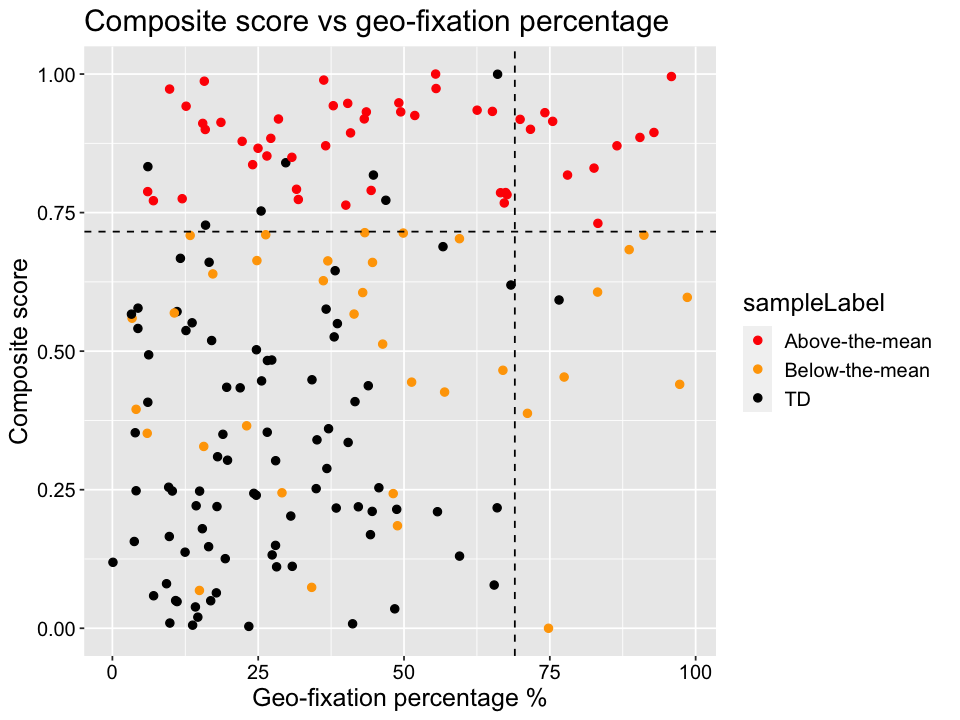

In [53]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Composite score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))


In [54]:
dddd$geo_weighted = dddd$weightedEstimate
dddd$geo_weighted[dddd$geo_per>69]=1

In [55]:
.myClassificationEvaluationFn(dddd$weightedEstimate,dddd$real)
.myClassificationEvaluationFn(dddd$geo_weighted,dddd$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8599518

$PR
[1] 0.8456124

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.86

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8456124 

    Area under curve (Davis & Goadrich):
     0.8453675 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8845639

$PR
[1] 0.8781891

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.8846

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8781891 

    Area under curve (Davis & Goadrich):
     0.8781838 

    Curve not computed ( can be done by using curve=TRUE )


In [56]:
.myClassificationEvaluationFn(dddd[dddd$group=='main', ]$weightedEstimate,dddd[dddd$group=='main', ]$real)
.myClassificationEvaluationFn(dddd[dddd$group=='test', ]$weightedEstimate,dddd[dddd$group=='test', ]$real)
.myClassificationEvaluationFn(dddd[dddd$group=='main', ]$geo_weighted,dddd[dddd$group=='main', ]$real)
.myClassificationEvaluationFn(dddd[dddd$group=='test', ]$geo_weighted,dddd[dddd$group=='test', ]$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8589862

$PR
[1] 0.8535496

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 62 controls (testLabels 0) < 70 cases (testLabels 1).
Area under the curve: 0.859

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8535496 

    Area under curve (Davis & Goadrich):
     0.8532553 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.9021164

$PR
[1] 0.8768943

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 27 controls (testLabels 0) < 14 cases (testLabels 1).
Area under the curve: 0.9021

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8768943 

    Area under curve (Davis & Goadrich):
     0.8768233 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8820276

$PR
[1] 0.8809307

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 62 controls (testLabels 0) < 70 cases (testLabels 1).
Area under the curve: 0.882

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8809307 

    Area under curve (Davis & Goadrich):
     0.8809219 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.9047619

$PR
[1] 0.88442

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 27 controls (testLabels 0) < 14 cases (testLabels 1).
Area under the curve: 0.9048

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.88442 

    Area under curve (Davis & Goadrich):
     0.884363 

    Curve not computed ( can be done by using curve=TRUE )


In [57]:
dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),]

,subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel,geo_weighted
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>
1,A2Y4H,1ST_GOOD,61.39,51.848835,223,0.925229896,1,main,10,ASD,35.483,Above-the-mean,0.925229896
2,A3W6D,1ST_GOOD,54.14,3.380126,68,0.559470280,1,test,15,ASD,36.205,Below-the-mean,0.559470280
3,A5G5M,1ST_GOOD,56.09,78.035300,80,0.817734971,1,test,11,ASD,32.066,Above-the-mean,1.000000000
4,A9P5P,1ST_GOOD,59.26,3.914951,363,0.352785778,0,main,2,TD,47.376,TD,0.352785778
5,B2J9W,1ST_GOOD,48.11,43.275826,135,0.713802190,1,main,13,ASD,34.760,Below-the-mean,0.713802190
6,B4C2A,1ST_GOOD,56.89,65.459659,168,0.077975396,0,main,5,TD,31.540,TD,0.077975396
7,B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.433822741,0,main,2,TD,44.715,TD,0.433822741
8,B4V3N,1ST_GOOD,46.34,36.167458,275,0.627106524,1,main,13,ASD,31.639,Below-the-mean,0.627106524
9,B4Z9C,1ST_GOOD,35.22,24.247587,249,0.243480115,0,test,0,TD,37.749,TD,0.243480115


Saving 7 x 7 in image



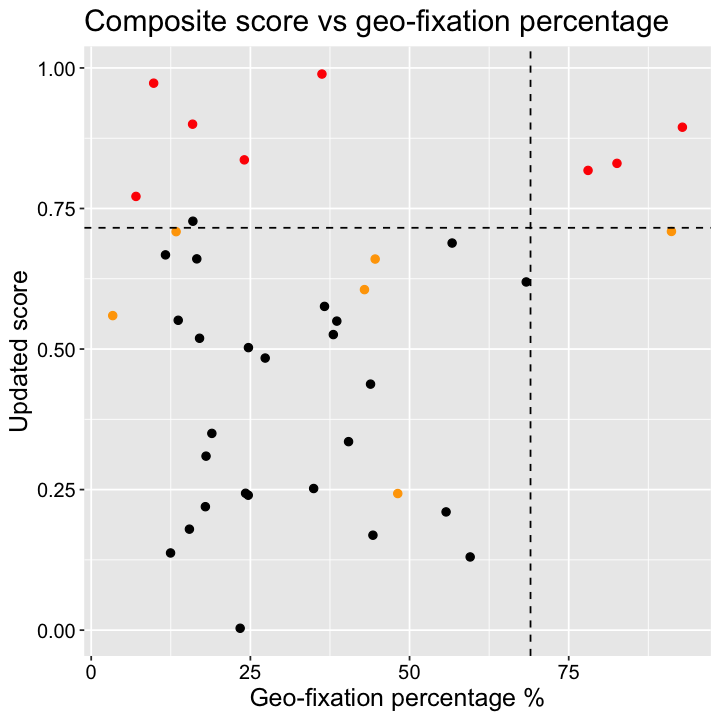

In [58]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_test.pdf"))

Saving 7 x 7 in image



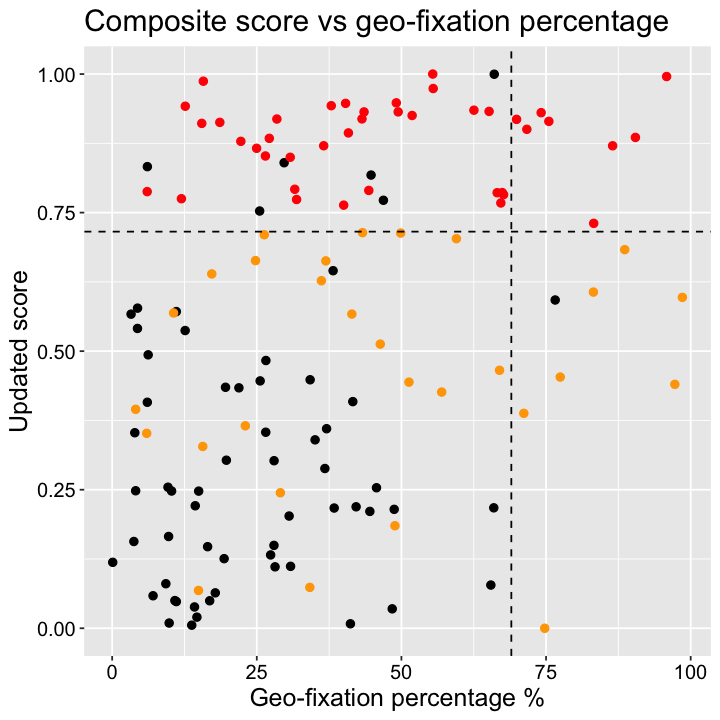

In [59]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main', ]
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_main.pdf"))

[1] 132

Saving 7 x 7 in image



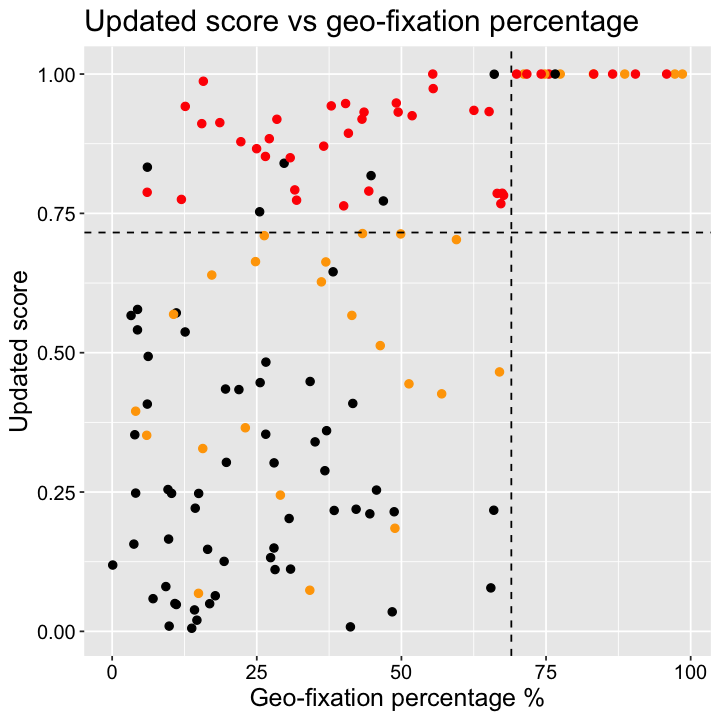

In [60]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main',]
nrow(dddd_main)
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),], aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none", axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Updated_score_vs_geo_fixation_percentage_main.pdf"))

[1] 41

Saving 7 x 7 in image



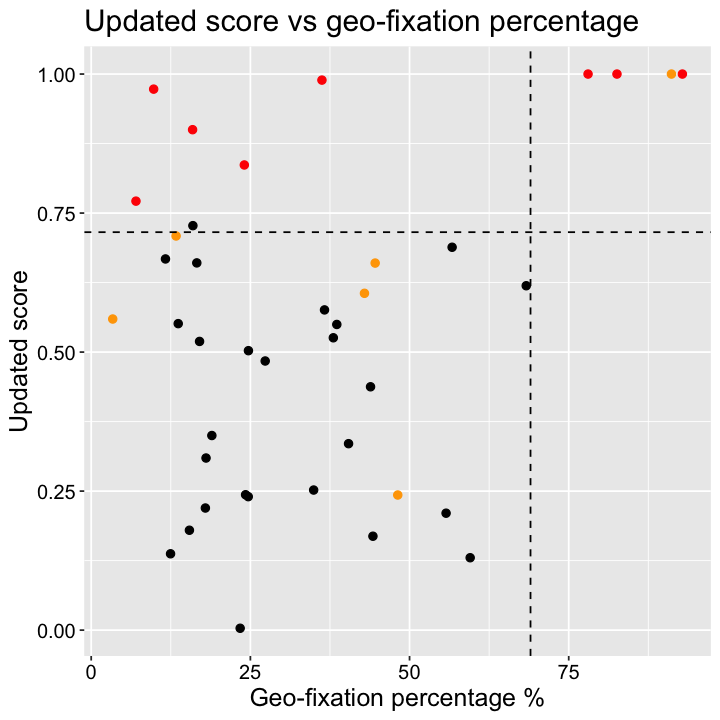

In [61]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
nrow(dddd_test)
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath, "Updated_score_vs_geo_fixation_percentage_test.pdf"))

In [62]:
akk = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/data_classification_clinical_scores.csv')

cosmos = merge(akk, concensus_all[,c('subjectID','sampleLabel' )], by.x="subjectid", by.y="subjectID")

a = c('recentDxJ_ageMo',
      'final_ados_CoSoTot',
      'final_ados_RRTot',
      'final_ados_CoSoTotRRTot',
      'final_vine_ComTotal_DomStd',
      'final_vine_DlyTotal_DomStd',
      'final_vine_SocTotal_DomStd',
      'final_vine_MtrTotal_DomStd',
      'final_vine_AdapBehav_DomStd',
      'final_vine_DomStdTotal',
      'final_mullen_VRT',
      'final_mullen_FMT',
      'final_mullen_RLT',
      'final_mullen_ELT',
      'final_mullen_ELC_Std')
category = c('Above-the-mean', 'Below-the-mean', 'TD')
for(i in a){
    print(i)
    for(group in category){
        print(group)
        print(nrow(cosmos[cosmos$sampleLabel==group,]))
        print(mean(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
        print(sd(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
    }
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[2],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[2],i], cosmos[cosmos$sampleLabel==category[3],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[3],i]))
}


[1] "recentDxJ_ageMo"
[1] "Above-the-mean"
[1] 79
[1] 45.77637
[1] 21.53113
[1] "Below-the-mean"
[1] 48
[1] 56.63656
[1] 36.56464
[1] "TD"
[1] 113
[1] 35.79913
[1] 10.8799

	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == category[2], i]
t = -1.8702, df = 67.096, p-value = 0.06582
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -22.4508107   0.7304199
sample estimates:
mean of x mean of y 
 45.77637  56.63656 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[2], i] and cosmos[cosmos$sampleLabel == category[3], i]
t = 3.876, df = 50.572, p-value = 0.0003069
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 10.04248 31.63238
sample estimates:
mean of x mean of y 
 56.63656  35.79913 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == category

In [63]:
.myDEanalysisFn=function(inputData){
  model=model.matrix(~0+sampleLabel,data=inputData)
  colnames(model)=c("above","below","TD")
  fit = lmFit(inputData,design=model)
  
  contrast1=makeContrasts(below-TD,above-TD,levels=model)
  fit=contrasts.fit(fit,contrasts=contrast1)
  fit=eBayes(fit,robust = T)
  asdGood=topTable(fit,number=dim(fit)[1],coef="above - TD");
  asdPoor=topTable(fit,number=dim(fit)[1],coef="below - TD");
  
  pvalDf=data.frame(class="Above-the-mean",pval=asdGood$P.Value,stringsAsFactors = F)
  pvalDf=rbind(pvalDf,data.frame(class="Below-the-mean",pval=asdPoor$P.Value,stringsAsFactors = F))
  return(list(goodClassification=asdGood,poorClassification=asdPoor,pvalDist=pvalDf))
}

# load("~/Documents/archive/UCSD_data/myData/classification_paper_main_ageBalanced_05162019.rda")



In [64]:
main_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_pheno_up.csv", row.names=1)
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
dataMain = dMain
dataMain$final_ADOS_CoSoTot = main_pheno_up[dataMain$sampleName, 'final_ADOS_CoSoTot']
dataMain$recentDxJ_dxCode = main_pheno_up[dataMain$sampleName, 'recentDxJ_dxCode']
dataMain$recentDxJ_ageMo = main_pheno_up[dataMain$sampleName, 'recentDxJ_ageMo']
dataMain$subjectID = main_pheno_up[dataMain$sampleName, 'subjectId']
dataMain$sampleLabel = "other"
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="TD"] = "TD"
mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"])
print('mean')
print(mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"]))
# the_mean = mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"])
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate>=the_mean] = "above"
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate<the_mean] = "below"
write.table(dataMain, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_consensus.csv",sep = ",")


test_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno_up.csv", row.names=1)
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
dataTest = tMain
dataTest$final_ADOS_CoSoTot = test_pheno_up[dataTest$sampleName, 'final_ADOS_CoSoTot']
dataTest$recentDxJ_dxCode = test_pheno_up[dataTest$sampleName, 'recentDxJ_dxCode']
dataTest$recentDxJ_ageMo = test_pheno_up[dataTest$sampleName, 'recentDxJ_ageMo']
dataTest$subjectID = test_pheno_up[dataTest$sampleName, 'subjectId']
dataTest$sampleLabel = "other"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="TD"] = "TD"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate>=the_mean] = "above"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate<the_mean] = "below"
write.table(dataTest$data$concensus, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_consensus.csv",sep = ",")


[1] 0.7156527

[1] "mean"
[1] 0.7156527


In [65]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/inputDataJabba_main.rda")
# write.table(inputExpData@featureData@data[,c("ILMN_Gene", "Entrez_Gene_ID")], "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/ilmn_gene.csv")
load('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plott/data_supplementary/all_usable_data.rda')


expMain=inputExpData[,match(dataMain$sampleName,colnames(inputExpData))]
expMain$sampleLabel = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="TD"] = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="other"] = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate>=the_mean] = "above"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate<the_mean] = "below"

expMain = expMain[row.names(expMain) %in% allProteinCodingGenes,]


DEmain=.myDEanalysisFn(expMain)
save(DEmain, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main.rda")
View(DEmain[['goodClassification']])

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:pROC’:

    var


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmi

,ID,Species,Source,Search_Key,Transcript,ILMN_Gene,Source_Reference_ID,RefSeq_ID,Unigene_ID,Entrez_Gene_ID,⋯,Synonyms,Obsolete_Probe_Id,GB_ACC,geneSymbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,⋯,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23523,ILMN_1814044,Homo sapiens,RefSeq,NM_012295.2,ILMN_11059,CABIN1,NM_012295.2,NM_012295.2,,23523,⋯,KIAA0330; CAIN,KIAA0330; CAIN,NM_012295.2,CABIN1,0.3592819,7.921335,7.486581,3.182189e-12,2.081605e-08,17.28828
6256,ILMN_1687315,Homo sapiens,RefSeq,NM_002957.3,ILMN_6758,RXRA,NM_002957.3,NM_002957.3,,6256,⋯,FLJ16020; FLJ16733; NR2B1; MGC102720,FLJ16020; FLJ16733; NR2B1; MGC102720,NM_002957.3,RXRA,0.3022740,10.141265,7.466745,3.559516e-12,2.081605e-08,17.18191
9638,ILMN_1779071,Homo sapiens,RefSeq,NM_005103.3,ILMN_28992,FEZ1,NM_005103.3,NM_005103.3,,9638,⋯,,,NM_005103.3,FEZ1,0.2752815,6.324893,7.168165,1.965126e-11,6.698937e-08,15.56158
81788,ILMN_2094952,Homo sapiens,RefSeq,NM_030952.1,ILMN_13538,NUAK2,NM_030952.1,NM_030952.1,,81788,⋯,DKFZP434J037; SNARK; DKFZp686F01113; FLJ90349,DKFZp686F01113; DKFZP434J037; SNARK; FLJ90349,NM_030952.1,NUAK2,0.2435467,8.423383,7.141042,2.291018e-11,6.698937e-08,15.41611
23492,ILMN_1657361,Homo sapiens,RefSeq,NM_175709.2,ILMN_22413,CBX7,NM_175709.2,NM_175709.2,,23492,⋯,,,NM_175709.2,CBX7,0.2752996,8.551180,7.046464,3.902690e-11,8.410083e-08,14.91120
57446,ILMN_1738229,Homo sapiens,RefSeq,NM_022477.2,ILMN_8447,NDRG3,NM_022477.2,NM_022477.2,,57446,⋯,FLJ13556,FLJ13556,NM_022477.2,NDRG3,0.1868639,8.565576,7.028585,4.314338e-11,8.410083e-08,14.81616
23067,ILMN_1813573,Homo sapiens,RefSeq,XM_941762.1,ILMN_168135,SETD1B,XM_037523.12,XM_037523.12,,23067,⋯,,,XM_037523.12,SETD1B,0.2131357,6.986990,6.979611,5.674201e-11,8.790565e-08,14.55652
10277,ILMN_1675674,Homo sapiens,RefSeq,NM_006048.2,ILMN_28085,UBE4B,NM_006048.2,NM_006048.2,,10277,⋯,HDNB1; UFD2; UBOX3; E4; KIAA0684; 686,HDNB1; UFD2; UBOX3; E4; KIAA0684; 686,NM_006048.2,UBE4B,0.1836592,7.926171,6.969231,6.012698e-11,8.790565e-08,14.50161
56666,ILMN_1694810,Homo sapiens,RefSeq,NM_052839.2,ILMN_4796,PANX2,NM_052839.2,NM_052839.2,,56666,⋯,hPANX2; MGC119432,hPANX2; MGC119432,NM_052839.2,PANX2,0.3714503,8.024975,6.887650,9.501083e-11,1.234719e-07,14.06825


In [66]:

#####################################


expMain_good = inputExpData[row.names(inputExpData) %in% allProteinCodingGenes,expMain$sampleLabe %in% c("good", 'TD')]
write.table(exprs(expMain_good), file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/expMain_good.txt",sep='\t')
output_table = DEmain[['goodClassification']][,c("geneSymbol", 'logFC',"adj.P.Val")]
colnames(output_table) = c('gene_name','log2FoldChange','padj')
write.table(output_table, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/DE_main_good.tsv",sep='\t')


########### step 1 ############
de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.01, ]
dim(de_main_good_gene)
# 
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID", "logp")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_with_rank_001.txt", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_001.txt", row.names = F, sep="\t")

########### step 2 ############

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene_2 = de_main_good_gene[(de_main_good_gene$adj.P.Val<0.05) & (abs(de_main_good_gene$logFC)>0.13), ]
dim(de_main_good_gene)

# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log2(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID","geneSymbol","logFC","AveExpr",'adj.P.Val')]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_good_gene.tsv", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_005_logfc013.txt", row.names = F, sep="\t")
############

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[(de_main_good_gene$adj.P.Val<0.01) & (abs(de_main_good_gene$logFC)>0.1), ]
dim(de_main_good_gene)
# length(intersect(de_main_good_gene_2$Entrez_Gene_ID, de_main_good_gene_1$Entrez_Gene_ID))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log2(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID", "logp")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_with_rank_001_logfc01.txt", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_001_logfc01.txt", row.names = F, sep="\t")
################


de_main_poor_gene = DEmain[['poorClassification']]
de_main_poor_gene = de_main_poor_gene[de_main_poor_gene$adj.P.Val<0.05, ]
dim(de_main_poor_gene)

length(DEmain[['goodClassification']]$adj.P.Val<0.05)

inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"pval_density_main_dataset.pdf"),width = 6, height = 4)
ggplot(DEmain$pvalDist,aes(pval,color=class,fill=class))+
  geom_density(size=1)+theme_bw()+scale_fill_manual(values=c(NA,"gray"))+scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+
  labs(x="p-value",  y="Density")

dev.off()
# rm(expMain,inputExpData)

# load("~/Documents/archive/UCSD_data/myData/classification_paper_testData_05162019.rda")
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/out1/data.rda")
testData = data[["testInputData"]]

expTest=testData[,match(dataTest$sampleName,colnames(testData))]
expTest$sampleLabel="other"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="TD"]="TD"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate>=the_mean]="above"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate<the_mean]="below"
expTest$sampleLabel[expTest$sampleLabel=="other"]="TD"
expTest = expTest[row.names(expTest) %in% allProteinCodingGenes,]

DEtest=.myDEanalysisFn(expTest)
save(DEtest, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_test.rda")

de_test_good_gene = DEtest[['goodClassification']]
de_test_good_gene = de_test_good_gene[de_test_good_gene$adj.P.Val<0.05, ]
dim(de_test_good_gene)
de_test_poor_gene = DEtest[['poorClassification']]
de_test_poor_gene = de_test_poor_gene[de_test_poor_gene$adj.P.Val<0.05, ]

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.05, c("Entrez_Gene_ID")]

length(intersect(de_test_good_gene$Entrez_Gene_ID, de_test_poor_gene$Entrez_Gene_ID))
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene))
kept = intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene)
kept = kept[!(kept %in% de_test_poor_gene$Entrez_Gene_ID)]
length(kept)
write.table(kept, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_goodClassification_without_rank_005.txt", row.names = F, sep="\t")


de_test_good_gene = de_test_good_gene[de_test_good_gene$adj.P.Val<0.01, ]
dim(de_test_good_gene)
de_test_poor_gene = de_test_poor_gene[de_test_poor_gene$adj.P.Val<0.01, ]
dim(de_test_poor_gene)
de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.01, c("Entrez_Gene_ID")]
length(de_main_good_gene)
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_test_poor_gene$Entrez_Gene_ID))
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene))
kept = intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene)
kept = kept[!(kept %in% de_test_poor_gene$Entrez_Gene_ID)]
length(kept)
write.table(kept, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_goodClassification_without_rank_001.txt", row.names = F, sep="\t")
#################
pdf(file=paste0(inputPath,"pval_density_test_dataset.pdf"),width = 6, height = 4)
ggplot(DEtest$pvalDist,aes(pval,color=class,fill=class))+
  # layer(geom = "area", mapping = aes(x = ifelse(x>-1.2 & x<1.1 , x, 0)),
  #         geom_params = list(fill = "red", alpha = 0.5))+
  geom_density(size=1)+theme_bw()+
  scale_fill_manual(values=c(NA,"gray"))+
  scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+labs(x="p-value",  y="Density")

dev.off()
# rm(expTest,testData)

#################
# expMain_Test = combine(expMain, expTest)
# DEmain_test=.myDEanalysisFn(expMain_Test)
# de_mainOtest_good_gene = DEmain_test[['goodClassification']]
# de_mainOtest_good_gene = de_mainOtest_good_gene[de_mainOtest_good_gene$adj.P.Val<0.01,]
# # de_mainOtest_good_gene$adj.P.Val
# de_mainOtest_good_gene = de_mainOtest_good_gene[order(de_mainOtest_good_gene$adj.P.Val),]
# de_mainOtest_good_gene = de_mainOtest_good_gene[,c("Entrez_Gene_ID")]
# write.table(intersect(asdProband[asdProband$adj.P.Val<0.05,c("Entrez_Gene_ID")], de_mainOtest_good_gene$Entrez_Gene_ID), file = "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/o_asdProband.txt", row.names = F, sep="\t")


# length(de_mainOtest_good_gene)

# de_mainOtest_poor_gene = DEmain_test[['poorClassification']]
# de_mainOtest_poor_gene = de_mainOtest_poor_gene[de_mainOtest_poor_gene$adj.P.Val<0.01, ]
# de_mainOtest_poor_gene = de_mainOtest_poor_gene[order(de_mainOtest_poor_gene$adj.P.Val), c("Entrez_Gene_ID")]


# length(de_mainOtest_good_gene)
# write.table(de_mainOtest_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_good_poorClassification_without_rank_001.txt", row.names = F, sep="\t")
# write.table(de_mainOtest_good_gene[1:1000], file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_good_poorClassification_without_rank_001_top1000.txt", row.names = F, sep="\t")



# gNet=.myNetGeneExtractorFn(netMProbandCombined)

[1] 1313   37

[1] 11696    37

[1] 1185   37

[1]  0 37

[1] 11696

pdf 
  2

[1] 2845   37

[1] 2

[1] 917

[1] 917

[1] 1561   37

[1]  0 37

[1] 1313

[1] 0

[1] 333

[1] 333

pdf 
  2

In [67]:
test_gene_table = read.table('/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_all_score_table_all.txt',header = TRUE)


In [68]:
nrow(test_gene_table)

[1] 3087

In [69]:
de_main_good = DEmain[['goodClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]
de_main_poor = DEmain[['poorClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]

de_main_poor_selected = de_main_poor[which(de_main_poor$Entrez_Gene_ID %in% test_gene_table$geneName),]
de_main_good_selected = de_main_good[which(de_main_good$Entrez_Gene_ID %in% test_gene_table$geneName),]

# length(test_gene_table$geneName)
length(de_main_poor$Entrez_Gene_ID)
# p_value_good = de_main_good[,'adj.P.Val']
# p_value_good = c(p_value_good, de_main_poor[,'adj.P.Val'])
# the_class = rep('goodClassification', length(de_main_good[,'adj.P.Val']))
# the_class = c(the_class, rep('poorClassification', length(de_main_good[,'adj.P.Val'])))
# tab <- data.frame(p_value = p_value_good, class= the_class)
# tab
# # pdf(file=paste0(inputPath,"pval_density_main_dataset_a.pdf"),width = 6, height = 4)
# ggplot(tab,aes(p_value,color=class,fill=class))+
#   geom_density(size=1)+theme_bw()+scale_fill_manual(values=c(NA,"gray"))+scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+
#   labs(x="p-value",  y="Density")

# dev.off()

[1] 11696

In [70]:
library(EnhancedVolcano)
library(airway)
library(magrittr)

Loading required package: ggrepel

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand


The following object is masked from ‘package:gplots’:

    space


The following object is masked from ‘package:base’:

    expand.grid


Loading required package: IRanges


Attaching package: ‘IRanges’


The following objects are masked from ‘package:dplyr’:

    collapse, desc, slice


The following object is masked from ‘package:purrr’:

    reduce


Loading required package: GenomeInfoDb

Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked

In [81]:
# data('airway')
# airway$dex %<>% relevel('untrt')
# ens <- rownames(airway)

# library(org.Hs.eg.db)
# symbols <- mapIds(org.Hs.eg.db, keys = ens,
# column = c('SYMBOL'), keytype = 'ENSEMBL')
# symbols <- symbols[!is.na(symbols)]
# symbols <- symbols[match(rownames(airway), names(symbols))]
# rownames(airway) <- symbols
# keep <- !is.na(rownames(airway))
# airway <- airway[keep,]
# library('DESeq2')

# dds <- DESeqDataSet(airway, design = ~ cell + dex)
# dds <- DESeq(dds, betaPrior=FALSE)
# res <- results(dds,
# contrast = c('dex','trt','untrt'))
# res <- lfcShrink(dds, contrast = c('dex','trt','untrt'), res=res, type = 'normal')

In [71]:
DEtest[['Above-the-mean']]

NULL

In [87]:
de_main_good_selected[['adj.P.Val']]

[1] 2.081605e-08 2.081605e-08 6.698937e-08 6.698937e-08 8.410083e-08
   [6] 8.410083e-08 8.790565e-08 8.790565e-08 1.234719e-07 1.496970e-07
  [11] 1.887935e-07 1.887935e-07 1.887935e-07 2.007413e-07 2.191681e-07
  [16] 2.534357e-07 3.979104e-07 3.979104e-07 4.380542e-07 6.765653e-07
  [21] 8.698432e-07 1.025338e-06 1.092555e-06 1.168291e-06 1.168291e-06
  [26] 1.168291e-06 1.452423e-06 1.495973e-06 1.741595e-06 2.183267e-06
  [31] 2.760171e-06 3.116129e-06 3.490573e-06 4.030600e-06 4.030600e-06
  [36] 4.834397e-06 5.115995e-06 5.949126e-06 6.009818e-06 6.440783e-06
  [41] 6.440783e-06 6.440783e-06 6.440783e-06 6.440783e-06 6.616447e-06
  [46] 6.718809e-06 7.022131e-06 8.299021e-06 9.065147e-06 9.065147e-06
  [51] 9.065147e-06 9.441267e-06 9.441267e-06 9.441267e-06 9.441267e-06
  [56] 9.441267e-06 9.441267e-06 9.594807e-06 9.600596e-06 1.019993e-05
  [61] 1.037527e-05 1.149230e-05 1.153830e-05 1.213548e-05 1.239701e-05
  [66] 1.441641e-05 1.441641e-05 1.671034e-05 1.673916e-05 1.722992e-05
  [71] 1.849062e-05 1.849062e-05 1.940768e-05 1.940768e-05 1.940768e-05
  [76] 2.032774e-05 2.054738e-05 2.054738e-05 2.150481e-05 2.164092e-05
  [81] 2.236951e-05 2.570558e-05 2.570558e-05 2.660498e-05 2.708633e-05
  [86] 2.751676e-05 2.817602e-05 3.078542e-05 3.078542e-05 3.106558e-05
  [91] 3.132340e-05 3.132340e-05 3.132340e-05 3.132340e-05 3.132340e-05
  [96] 3.132340e-05 3.132340e-05 3.132340e-05 3.132340e-05 3.223773e-05
 [101] 3.313313e-05 3.326705e-05 3.326705e-05 3.426862e-05 3.470175e-05
 [106] 3.825918e-05 4.095981e-05 4.152142e-05 4.152142e-05 4.152142e-05
 [111] 4.152142e-05 4.152142e-05 4.152142e-05 4.185471e-05 4.185471e-05
 [116] 4.452915e-05 4.640129e-05 4.721618e-05 4.768567e-05 4.821124e-05
 [121] 4.922584e-05 5.112637e-05 5.190159e-05 5.190159e-05 5.394506e-05
 [126] 5.446822e-05 5.534430e-05 5.534430e-05 5.534430e-05 5.534430e-05
 [131] 5.691328e-05 5.691328e-05 5.691328e-05 5.730125e-05 6.192441e-05
 [136] 6.320426e-05 6.608033e-05 7.102028e-05 7.111849e-05 7.351268e-05
 [141] 7.351268e-05 7.378380e-05 7.570892e-05 7.570892e-05 7.640356e-05
 [146] 7.640356e-05 7.640356e-05 7.653406e-05 8.131579e-05 8.208649e-05
 [151] 8.272893e-05 8.295505e-05 8.295505e-05 8.295505e-05 8.309865e-05
 [156] 8.330533e-05 8.338654e-05 8.417915e-05 8.417915e-05 8.713014e-05
 [161] 8.760245e-05 8.760245e-05 8.760245e-05 8.760245e-05 9.223744e-05
 [166] 9.223744e-05 9.223744e-05 9.447344e-05 9.454576e-05 9.674636e-05
 [171] 9.810456e-05 9.870119e-05 9.870119e-05 1.000749e-04 1.000749e-04
 [176] 1.000749e-04 1.050687e-04 1.063652e-04 1.075437e-04 1.104299e-04
 [181] 1.109997e-04 1.123271e-04 1.173373e-04 1.187431e-04 1.195946e-04
 [186] 1.205798e-04 1.207290e-04 1.231820e-04 1.238352e-04 1.241183e-04
 [191] 1.322173e-04 1.327050e-04 1.358469e-04 1.433411e-04 1.488289e-04
 [196] 1.489271e-04 1.493241e-04 1.499210e-04 1.504429e-04 1.589704e-04
 [201] 1.589704e-04 1.628774e-04 1.676568e-04 1.685541e-04 1.685541e-04
 [206] 1.720971e-04 1.730375e-04 1.732560e-04 1.732560e-04 1.779567e-04
 [211] 1.821662e-04 1.821662e-04 1.898889e-04 1.898889e-04 1.909933e-04
 [216] 1.929867e-04 1.935799e-04 1.959184e-04 1.959184e-04 1.975799e-04
 [221] 1.998346e-04 2.130763e-04 2.130763e-04 2.148997e-04 2.148997e-04
 [226] 2.148997e-04 2.181684e-04 2.181684e-04 2.192015e-04 2.227053e-04
 [231] 2.271687e-04 2.331003e-04 2.341124e-04 2.347366e-04 2.400685e-04
 [236] 2.408177e-04 2.453399e-04 2.505494e-04 2.534011e-04 2.534011e-04
 [241] 2.535710e-04 2.539118e-04 2.539118e-04 2.539118e-04 2.621827e-04
 [246] 2.621827e-04 2.621827e-04 2.670140e-04 2.670140e-04 2.675862e-04
 [251] 2.675862e-04 2.675862e-04 2.676303e-04 2.676303e-04 2.676303e-04
 [256] 2.676303e-04 2.676303e-04 2.694904e-04 2.694904e-04 2.735126e-04
 [261] 2.735126e-04 2.735126e-04 2.735126e-04 2.735668e-04 2.736473e-04
 [266] 2.767283e-04 2.767283e-04 2.767283e-04 2.767283e-04 2.781846e-04
 [271] 2.781846e-04 2.797846e-04 2.797846e-04 2.797846e-04 2.827653e-04
 [276] 2.827653e-04 2.827653e-04 2.839827e-

In [89]:
de_test_good[which(de_test_good[['adj.P.Val']]<0.01 & de_test_good$logFC <0.1),]

,Entrez_Gene_ID,logFC,adj.P.Val,P.Value,geneSymbol
,<int>,<dbl>,<dbl>,<dbl>,<chr>
10643,10643,-0.6044791,4.319253e-10,3.692932e-14,IGF2BP3
285172,285172,-0.5995324,1.324586e-07,3.397535e-11,FAM126B
51668,51668,-0.3905752,2.271358e-05,1.184617e-07,HSPB11
4893,4893,-0.2975521,2.320513e-05,1.340533e-07,NRAS
5684,5684,-0.3797371,3.124535e-05,1.923448e-07,PSMA3
112495,112495,-0.3265360,3.536817e-05,2.424719e-07,GTF3C6
10140,10140,-0.3039489,4.684253e-05,4.205255e-07,TOB1
10189,10189,-0.3085236,4.848898e-05,4.681503e-07,ALYREF
401505,401505,-0.3347653,5.123592e-05,5.212957e-07,TOMM5


In [79]:
nrow(de_main_good_selected)

[1] 2721

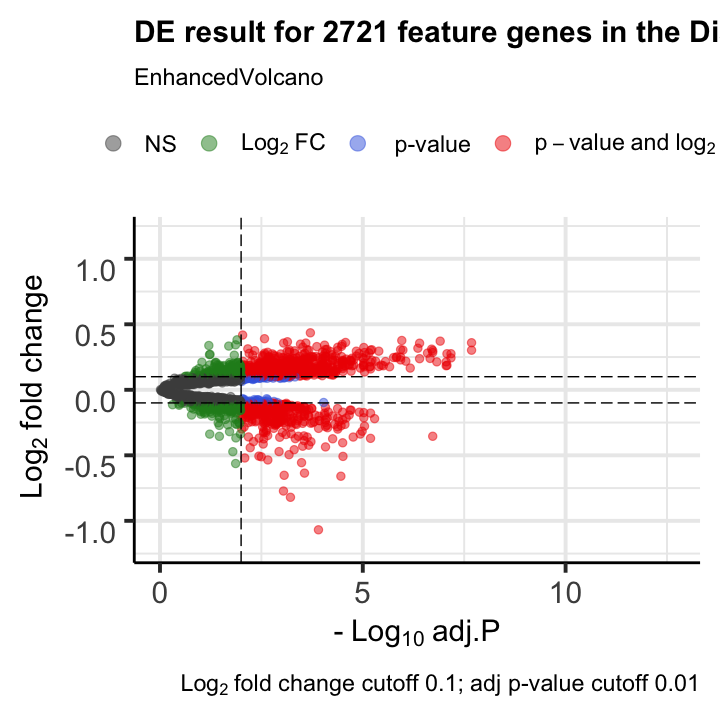

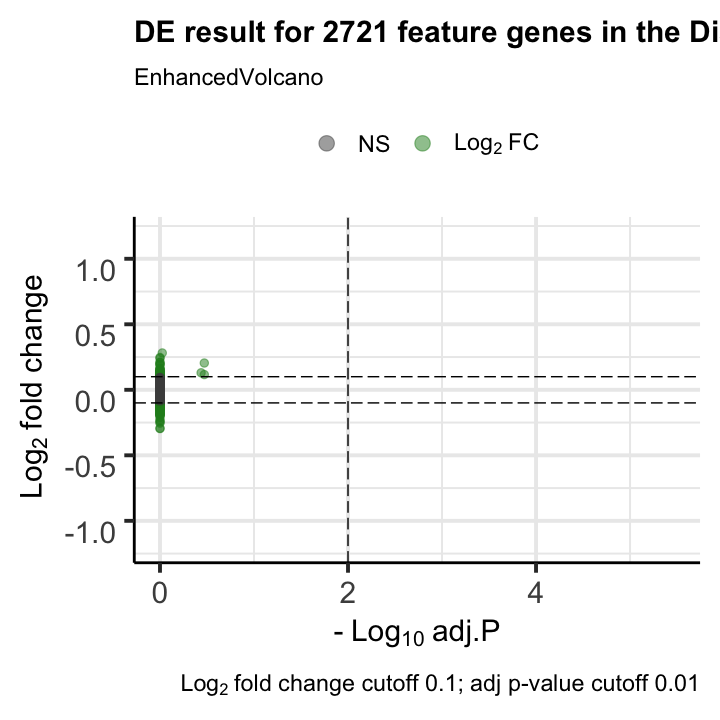

In [76]:
p=EnhancedVolcano(de_main_good_selected,
    lab = de_main_good_selected$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2721 feature genes in the Discovery Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()
                  
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"main_above_volcano.pdf"))

p=EnhancedVolcano(de_main_poor_selected,
    lab = de_main_poor_selected$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2721 feature genes in the Discovery Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()
                  
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"main_below_volcano.pdf"))
# EnhancedVolcano(de_main_good,
#     lab = rownames(de_main_good),
#     x = 'logFC',
#     y = "adj.P.Val",
#     pCutoff = 0.01,
#     FCcutoff = 0.1,
#     pointSize = 3.0,
#     title = "DE result for ",
#     subtitle = "Differential expression",
#     caption = bquote(~Log[2]~ "fold change cutoff, 2; p-value cutoff, 10e-4"),
#     legendPosition = "right",
#     legendLabSize = 14,
#     xlab="-"~Log[10]~"adjP"
#                )
# EnhancedVolcano(de_main_poor,
#     lab = rownames(de_main_poor),
#     x = 'logFC',
#     y = "adj.P.Val",
#     pCutoff = 0.01,
#     FCcutoff = 0.1,
#     pointSize = 3.0)

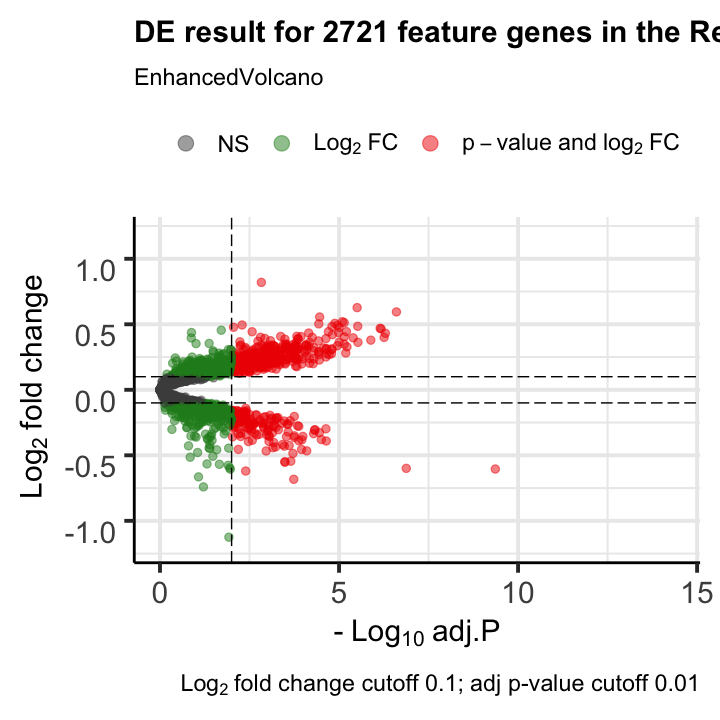

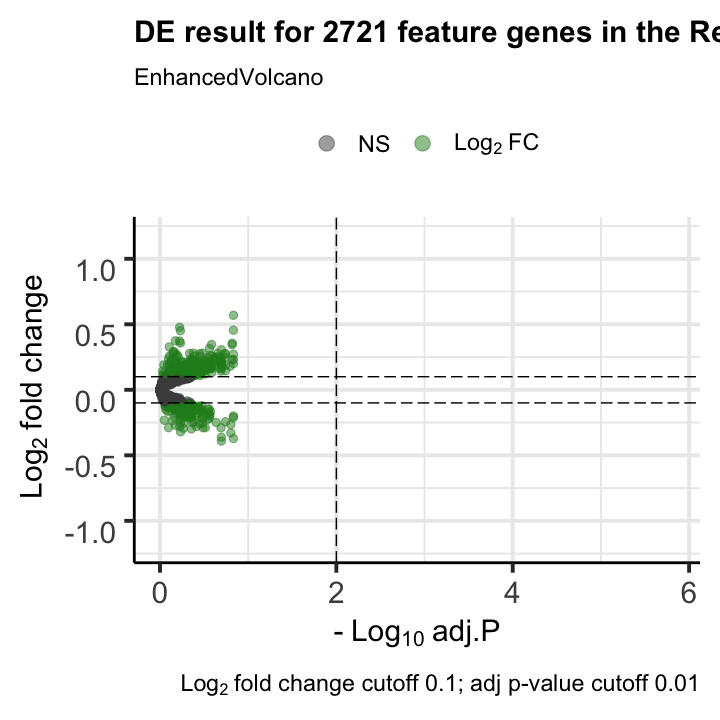

In [75]:
de_test_good = DEtest[['goodClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]
de_test_poor = DEtest[['poorClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]

de_test_poor = de_test_poor[which(de_test_poor$Entrez_Gene_ID %in% test_gene_table$geneName),]
de_test_good = de_test_good[which(de_test_good$Entrez_Gene_ID %in% test_gene_table$geneName),]
p=EnhancedVolcano(de_test_good,
    lab = de_test_good$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2721 feature genes in the Replication Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
#     legendIconSize = 4.0,
#     drawConnectors = TRUE,
#     widthConnectors = 1.0,
    labSize = 0,
    width=15) + coord_flip()

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"test_above_volcano.pdf"))
           
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p=EnhancedVolcano(de_test_poor,
    lab = de_test_poor$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2721 feature genes in the Replication Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"test_below_volcano.pdf"))
        

In [102]:
fisher.test(rbind(c(15840-1822,1822-1656), c(1822,1656)))



	Fisher's Exact Test for Count Data

data:  rbind(c(15840 - 1822, 1822 - 1656), c(1822, 1656))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 64.74134 91.39221
sample estimates:
odds ratio 
  76.89514 


In [88]:
fisher.test(rbind(c(15840-1822,1822-26), c(1822,26)))



	Fisher's Exact Test for Count Data

data:  rbind(c(15840 - 1822, 1822 - 26), c(1822, 26))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.07231532 0.16436198
sample estimates:
odds ratio 
 0.1113861 
